# **FEEDBACK**

	
**General comments:** missing in places;

**Plots:** image plots are not well scaled ;

**Formatting:** some spagetti code;

**Explanation on classifier design:** given summary of each attempt lacking reason why trying;

**Summary of final classifier:** Final classification summary some understanding given.;

# ASTR3110 Computer Laboratory 3: Classifying Images using Artificial and Convolutional Neural Networks.


In this Lab, you will be using imaging from the [CORNISH](https://cornish.leeds.ac.uk/public/index.php) survey to classify images using Neural Networks. The CORNISH survey aimed to understand massive star formation in our Galaxy by searching for ultra-compact HII regions (regions that have stars with mass > 8 times the mass of our Sun that are ionising the surrounding gas, which emit at radio wavelengths) in a portion of the plane of the disk of the Galaxy using the [Very Large Array Radio telescope](http://www.vla.nrao.edu). 

While this survey successfully discovered many new HII regions, other sources such as planetary nebulae (PNE) and background galaxies (RGs) also emit at radio wavelengths, and so were also detected in the survey data. By design, the CORNISH survey targetted a region that also contained observations in the mid-infrared taken drung another survey with the Spitzer Space telescope ([the GLIMPSE survey](https://irsa.ipac.caltech.edu/data/SPITZER/GLIMPSE/)). In particular, the 4.5, 5.8, and 8.0 $\mu$m Spitzer images allow us to distinguish HII regions, PNE, and RGs due to their differnt appearance (see top panel in the below image: leftmost is a PNE, middle a HII region, and right a RG).

![SegmentLocal](CORNISH_image.png)

In the first part of the lab, you will train and test an Artificial Neural Network classifier using 300 8.0 $\mu$m images (100 each for HII, PNE, and RG sources).

In the second part of the lab, you will train and test a Convolutional Neural Network classifier, using the same sample as in Part One, but adding the 4.5 and 5.8 $\mu$m images. 

In both parts, you will need to run tests to determine the performance of your classifier, and tweak hyperparameters  in order to improve the performance. (N.B.: The term "hyperparameter" is reserved for those parameters that are set manually, e.g., the number of components in GMM, or the learning rate of your neural network. Normal parameters are determined from the data, e.g., the intercept and slope of a straight line fit)

## **If you are using google Colab, you may wish to switch to using a GPU hardware accelerator, as this can improve the speed of the Neural Networks. To do so, go to the "Edit" dropdown, click "Notebook Settings", and select "GPU" for the hardware accelerator. This needs to be done before you start coding!**

At the completion of this lab, you will have acquired (or improved) the following skills:
- Reading in fits images using astropy.
- Manipulating 2D image arrays to prepare them for input into the ANN and CNN architectures (using the ndimage and numpy packages).
- Using the keras packages for setting up and running ANN and CNN. classifiers.
- Using Scikit Learn and other packages to assess the performance of ANN and CNN classifiers.

You will need to turn in your completed notebook for marking (an upload link appear on iLearn later). You will be marked on the following with equal weight:
- Comments: Your code must be commented. You can either do this by adding explanation text placed in blocks just before code blocks OR as comments within the code blocks themselves. Your comments should demonstrate that you understand what your code is doing, and why! You will be marked based on the clarity of your comments, and whether your comments indicate that you understand your code. If using markdown cells, please consider using colour to distinguish your comments from the existing instructions in the notebook.
- Plots should be well presented and explained: E.g., reasonable axes (e.g., ranges should be set so that trends are clearly visible), clear axis labels. You should also explain the "why" and "what" of your plots. Why are you plotting this? What does your plot show?
- Formatting of your code (easy to understand, sensible variable names etc.)
- Clear explanations and/or justifications of experiments to design a better classifier.
- Comments and explanation on a final best classifier and performance results.

# Part 1: Artificial Neural Networks

In this part, we will use the 8.0 $\mu$m images to design a classifier using the keras backend to build ANNs in a similar manner to that described in the [Week 9 lectorial](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/Solution_Notebooks/ASTR3110_Tutorial_9_ANNs.ipynb). First, the data must be read in and manipulated into a format that is accepted by the keras models.

## Accessing the data.


<font color='red'>

You should clone the Github repository to your Google Drive as per the usual method [described here](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/SETUP_COLAB.md). **Please clone into a new directory so that you do not overwrite existing Labs!!**

As outlined above, the data that will be used in this lab consist of Spitzer imaging in the 4.5, 5.8, and 8.0 $\mu$m bands. The images have been uploaded to the [Github repository](https://github.com/MQ-ASTR3110-2021/ASTR3110_Practical_Notebooks_2021/), and are stored the main ```Cornish_data``` directory, which contains three subdirectories: one each for ```HII```, ```PNE```, and ```RG``` sources. Within each of these subdirectories, there are 300 "fits" files: 3 files for each source, where the filename gives the Galactic coordinates, and the 3 fiels are for the different Spitzer bands (I2 = 4.5 $\mu$m, I3 = 5.8 $\mu$m, and I4 = 8.0 $\mu$m). </font>

In [1]:
# Importing all the necessary modules and functions:
import numpy as np
import glob
import itertools

from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras import backend as K
from keras.models import Sequential # Model used to create the architecture both ANNs and CNNs
from keras.layers.core import Dense 
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D # For CNNs
from keras.layers.convolutional import MaxPooling2D # For CNNs
from keras.layers.core import Flatten # For CNNs
from keras.layers.core import Activation # For CNNs
from keras.layers.core import Dropout # For CNNs

# dir = 'Cornish_data/'
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Setting path variables

In [3]:
root = 'gdrive/MyDrive/ASTR3110/OLD/Prac03'
data = '/Cornish_data'

###  Getting to know the data

<font color='red'>The fits format is commonly used for storing astronomical data, and can store binary tables, images, cubes, and other formats (the format is also used by Garmin, Strava and other activity trackers), as well as coordinate and information for the image in a header. Fits files can be read into numpy arrays using the [astropy.io.fits](https://docs.astropy.org/en/stable/io/fits/#) package. 

Using the astropy.io.fits.getdata() function, read in a source from each of the HII, PNE, and RG folders. At this point, we only require access to the 8.0 $\mu$m band images (labelled \*_I4.fits). Using numpy functions, determine basic statistics for the images (min, max pixel values, and shape of the array). Plot the images for the three sources to convince yourself that they appear different.</font>

In [4]:
hii_1 = fits.getdata(root + '/' + data + '/HII/G011.1712-00.0662_I4.fits')
hii_2 = fits.getdata(root + '/' + data + '/HII/G011.1104-00.3985_I4.fits')
hii_3 = fits.getdata(root + '/' + data + '/HII/G010.8519-00.4407_I4.fits')

pne_1 = fits.getdata(root + '/' + data +'/PNE/G009.9702-00.5292_I4.fits')
pne_2 = fits.getdata(root + '/' + data +'/PNE/G010.0989+00.7393_I4.fits')
pne_3 = fits.getdata(root + '/' + data +'/PNE/G010.4168+00.9356_I4.fits')

rg_1 = fits.getdata(root + '/' + data +'/RG/G010.0500-00.6863_I4.fits')
rg_2 =  fits.getdata(root + '/' + data +'/RG/G011.7182-00.9321_I4.fits')
rg_3 = fits.getdata(root + '/' + data +'/RG/G011.9222+01.0978_I4.fits')

plotting from https://docs.astropy.org/en/stable/generated/examples/io/plot_fits-image.html

to change the min pixel values https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

In [5]:
hii_1.shape

(302, 302)

Images are shape 302x302

In [6]:
from matplotlib.colors import LogNorm

Plotting to see what these 9 images look like

Text(0.5, 1.0, 'rg_3')

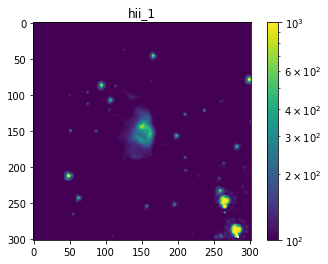

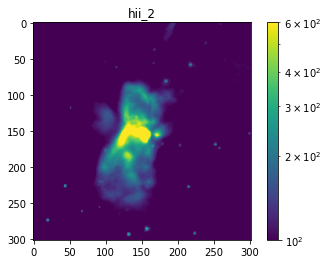

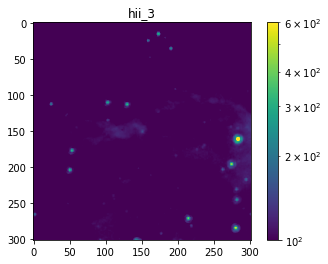

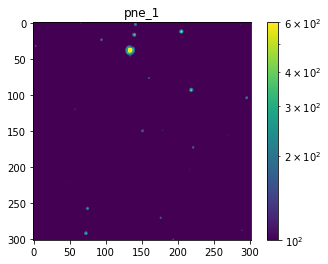

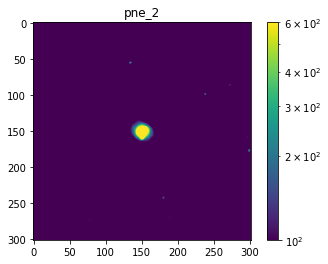

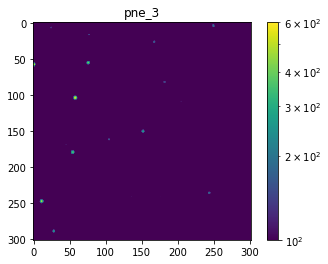

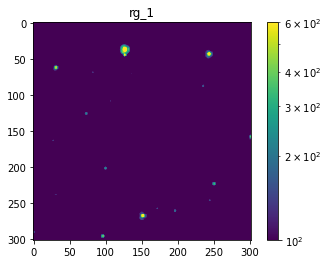

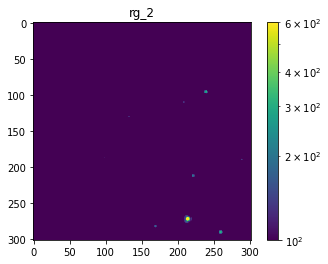

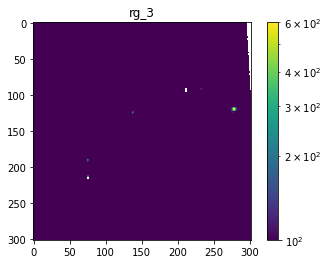

In [7]:
# print(hii_1)
plt.figure()
plt.imshow(hii_1,vmin=100,vmax=1000,norm=LogNorm()) #log scaling for the pixels. Makes makes darker pixels more noticeable
#and the brighter pixels less intense. 

# plt.imshow(hii_1,norm=LogNorm())
plt.colorbar()
plt.title('hii_1')

plt.figure()
plt.imshow(hii_2,vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('hii_2')

plt.figure()
plt.imshow(hii_3,vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('hii_3')

#---------------------------------------------------------

plt.figure()
plt.imshow(pne_1,vmin=100,vmax=600,norm=LogNorm())
# plt.imshow(hii_1,norm=LogNorm())
plt.colorbar()
plt.title('pne_1')


plt.figure()
plt.imshow(pne_2,vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('pne_2')

plt.figure()
plt.imshow(pne_3,vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('pne_3')

#---------------------------------------------------------


plt.figure()
plt.imshow(rg_1,vmin=100,vmax=600,norm=LogNorm())
# plt.imshow(hii_1,norm=LogNorm())
plt.colorbar()
plt.title('rg_1')


plt.figure()
plt.imshow(rg_2,vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('rg_2')

plt.figure()
plt.imshow(rg_3,vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('rg_3')

<font color='red'>
Because the images are relatively large, we want to resize them in order to decrease the runtime when we run our neural networks. Use the [scipy.ndimage.zoom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html) function to bin the images to a coarser pixel scale. Plot the resulting coarsely binned image and compare with the original for each of the three sources. Try a few different 'zoom' factors and choose a suitable factor by which to reduce the size of your images. Note, you do not want to bin too much, otherwise you lose too much information. 

</font>

Using the `zoom` function to zoom into the images.

In [8]:
from scipy import ndimage, misc

hiiZoom_1 = ndimage.zoom(hii_1,0.5)
hiiZoom_2 = ndimage.zoom(hii_2,0.5)
hiiZoom_3 = ndimage.zoom(hii_3,0.5)

pneZoom_1 = ndimage.zoom(pne_1,0.5)
pneZoom_2 = ndimage.zoom(pne_2,0.5)
pneZoom_3 = ndimage.zoom(pne_3,0.5)

rgZoom_1 = ndimage.zoom(rg_1,0.5)
rgZoom_2 = ndimage.zoom(rg_2,0.5)
rgZoom_3 = ndimage.zoom(rg_3,0.5)


Plotting only two images to check if they have been zoomed. 

Text(0.5, 1.0, 'hii_1 zoom')

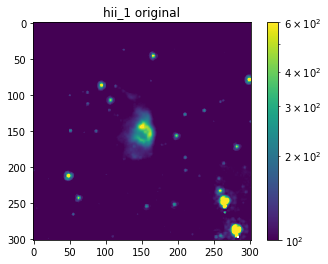

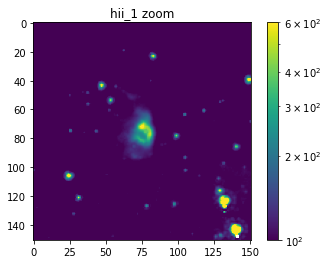

In [9]:
plt.figure()
plt.imshow(hii_1,vmin=100,vmax=600,norm=LogNorm())
# plt.imshow(hii_1,norm=LogNorm())
plt.colorbar()
plt.title('hii_1 original')

plt.figure()
plt.imshow(hiiZoom_1,vmin=100,vmax=600,norm=LogNorm())
# plt.imshow(hii_1,norm=LogNorm())
plt.colorbar()
plt.title('hii_1 zoom')

They have been zoomed

## Preparing the data for the ANN


As you know from lectorial 9, as input to the ANN we require the images to be flattened to 1D arrays, and also normalised so that the pixel values are between 0 and 1. We also require labels for the sources (both single digit labels as well as the one-hot vectors of binarized labels), and a training and testing/validation sample. 

To achieve some of the above, I suggest that you write a function that:
- accepts a directory path + fits filename (e.g., Cornish_data/HII/G010.8519-00.4407_I4.fits),
- reads the fits file using astropy.io.getdata,
- resizes the image,
- normalises the pixels values to be between 0 and 1,
- flattens the 2D images into 1D,
- returns the resized, normalised, flattened 1D array

You can use the [glob](https://docs.python.org/3/library/glob.html) function to return a list of filenames that can be looped over and read in by your function. You will need to stack each flattened image into a larger array that contains all 300 sources. In addition, you will need the corresponding 1D vector of labels, as well as the binarized version.

Finally, you will need to split your data into a training and testing/validation dataset (recall scikit learn's handy [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function).</font>

## Reading the data as a function

glob gives list of all the names. 

In [10]:
import glob

There are 100 files for each object (hii, pne, rg) so a total of 300 files. Using the `glob.glob` function is already inside the directory where the data is located. 

In [11]:
def globFn(objectDir: str):
    #stores the file names in a list
    fitsFileNames = glob.glob(root + data + '/' + objectDir +'/*_I4.fits') # Where the asterisk symbol acts as a wildcard
    return fitsFileNames

In [12]:
def readFileFn(objectDir: str):
    fitsImages= []
    files=(globFn(root + data + '/' + objectDir))
    #uses the stored file names and gets the data from them with the fits.getdata function, stores it in a list. 
    for i in files:
        fitsImages.append(fits.getdata(i))
    return fitsImages

Calling the function for each object, `glob.glob` is case sensitive:

The above function `readFileFn` isn't working, so taking the code out of the function to do it manually: 

In [13]:
hii_DF_raw = []
for i in glob.glob('gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/HII' + '/*_I4.fits'):
  hii_DF_raw.append(fits.getdata(i))


pne_DF_raw = []
for i in glob.glob('gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/PNE' + '/*_I4.fits'):
  pne_DF_raw.append(fits.getdata(i))


rg_DF_raw = []
for i in glob.glob('gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG' + '/*_I4.fits'):
  rg_DF_raw.append(fits.getdata(i))

To confirm the shapes of the DFs, so that we know our functions have worked: 

In [14]:
print(len(hii_DF_raw))
print(len(pne_DF_raw))
print(len(rg_DF_raw))

100
100
100


Checking the size of a single image in the collection:

In [15]:
len(rg_DF_raw[0])

302

## Resizing and reshaping the images

In [16]:
def resizeFn(DF,zoomFactor):
    DF_zoom= ndimage.zoom(DF, zoomFactor)
    return DF_zoom

zoomFactor= (1,0.5,0.5)
hii_DF_zoom = resizeFn(hii_DF_raw, zoomFactor)
pne_DF_zoom = resizeFn(pne_DF_raw,zoomFactor)
rg_DF_zoom = resizeFn(rg_DF_raw, zoomFactor)

In [17]:
rg_DF_zoom.shape

(100, 151, 151)

The following cell has only a single value for the zoom factor, like how Brandon has done it. I'm not sure why the previous cell had a list of values. 

In [18]:
def resizeFn(DF,zoomFactor):
    DF_zoom= ndimage.zoom(DF, zoomFactor)
    return DF_zoom

zoomFactor= 0.6
hii_DF_zoom = resizeFn(hii_DF_raw, zoomFactor)
pne_DF_zoom = resizeFn(pne_DF_raw,zoomFactor)
rg_DF_zoom = resizeFn(rg_DF_raw, zoomFactor)

In [19]:
rg_DF_zoom.shape

(60, 181, 181)

Confirming the resize worked: 

Text(0.5, 1.0, 'hii_2 zoom')

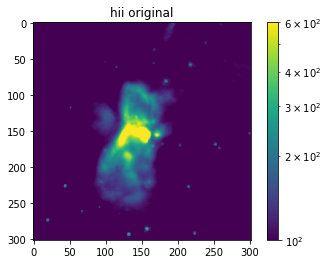

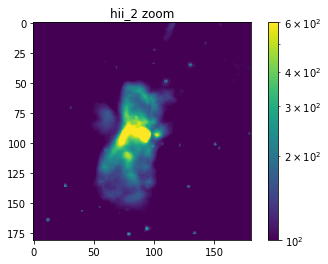

In [20]:
plt.figure()
plt.imshow(hii_DF_raw[0],vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('hii original')

plt.figure()
plt.imshow(hii_DF_zoom[0],vmin=100,vmax=600,norm=LogNorm())
# plt.imshow(hii_1,norm=LogNorm())
plt.colorbar()
plt.title('hii_2 zoom')

Checking the axes, we can see the images have been resized. 

## Normalisation

In [21]:
arrZeros= np.zeros((100,181,181))
for i in range(len(hii_DF_zoom)):
    arrZeros[i,:,:] = hii_DF_zoom[i,:,:] - hii_DF_zoom[i,:,:].min()
    arrZeros[i,:,:] = arrZeros[i,:,:]/arrZeros.max()
    hiiDF_norm= arrZeros
hiiDF_norm.shape

(100, 181, 181)

Confirming the normalisation worked

In [22]:
print('max value: ',hiiDF_norm.max(),'and min value: ', hiiDF_norm.min())

max value:  1.0 and min value:  0.0


Performing the same normalisation for the other two objects: 

In [23]:
arrZeros= np.zeros((100,181,181))
for i in range(len(pne_DF_zoom)):
    arrZeros[i,:,:] = pne_DF_zoom[i,:,:] - pne_DF_zoom[i,:,:].min()
    arrZeros[i,:,:] = arrZeros[i,:,:]/arrZeros.max()
    pneDF_norm = arrZeros    
pneDF_norm.shape

(100, 181, 181)

In [24]:
arrZeros= np.zeros((100,181,181))
for i in range(len(rg_DF_zoom)):
    arrZeros[i,:,:] = rg_DF_zoom[i,:,:] - rg_DF_zoom[i,:,:].min()
    arrZeros[i,:,:] = arrZeros[i,:,:]/arrZeros.max()
    rgDF_norm= arrZeros
rgDF_norm.shape

(100, 181, 181)

Now we want to flatten the images so that we can feed the ANN with 1D arrays. So first let's create an array to store the dimension of our DF

In [25]:
hii_DFdim = hiiDF_norm.shape

pne_DFdim = pneDF_norm.shape

rg_DFdim = rgDF_norm.shape
rg_DFdim

(100, 181, 181)

## Flattening

Flattening the images

In [26]:
len(hiiDF_norm[0].flatten())

32761

In [27]:
all_flat = []
for i, val in enumerate(hiiDF_norm):
  all_flat.append(hiiDF_norm[i].flatten())

for i, val in enumerate(pneDF_norm):
  all_flat.append(pneDF_norm[i].flatten())

for i, val in enumerate(rgDF_norm):
  all_flat.append(rgDF_norm[i].flatten())

all_flat = np.array(all_flat)

In [28]:
all_flat.shape

(300, 32761)

## Now will need the corresponding 1D vector of labels, as well as the binarized version

In [29]:
#creating the labels
hii_fileName = globFn('HII')
pne_fileName = globFn('PNE')
rg_fileName = globFn('RG')

#we want to now binarize these labels so that we can use them in our `trainTestSplitFn`
rg_fileName[0:10]

['gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G010.0500-00.6863_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G011.7182-00.9321_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G013.8826+00.5410_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G011.9222+01.0978_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G017.8566-00.0002_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G012.1225-00.5000_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G013.8700+00.5408_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G017.6618-00.3327_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G011.9709+00.1913_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G012.6550-00.9622_I4.fits']

In [30]:
allFileNames = np.concatenate((hii_fileName, pne_fileName, rg_fileName))
allFileNames.shape

(300,)

All the file names are in one list. Digitizing the strings:

In [31]:
labels = []

for i in range(len(allFileNames)):
#     print(i)
    if 'HII' in allFileNames[i]:
        labels.append(0)
#     if allFileNames[i]=='*PNE*' :
    if 'PNE' in allFileNames[i]:
        labels.append(1)
#     if allFileNames[i]=='*RG*' :
    if 'RG' in allFileNames[i]:
        labels.append(2)
        
labels= np.array(labels)
labels.shape

(300,)

In [32]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

we have our digitized 1D vector of labels `labels`. Splitting the dataframe and labels into train and test sets:

In [33]:
from sklearn.model_selection import train_test_split

#splitting the DF with the split function
trainSet, testSet, trainLabels, testLabels= train_test_split(all_flat, labels, stratify= labels, test_size= 0.3, random_state= 42)

testSet.shape

(90, 32761)

the first dimension, 90, represents 30% of 300 (all of our files)

In [34]:
print('train_labels shape: ', trainLabels.shape, 'and test_labels shape: ', testLabels.shape)

train_labels shape:  (210,) and test_labels shape:  (90,)


Everything has been split correctly, moving on to the binarizer process: 

In [35]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer() #sets the function to a variable, less writing.

#converting our labels which contain 0,1,2 into one-hot vector format which is required for the binarizor function
trainLabels = lb.fit_transform(trainLabels)
testLabels = lb.transform(testLabels) 

print('train_labels shape: ', trainLabels.shape, 'and test_labels shape: ', testLabels.shape)

train_labels shape:  (210, 3) and test_labels shape:  (90, 3)


hot vectors are now made

In [36]:
testLabels[0:10]

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]])

What the above represents is, whenever an index is populated with 1, this corresponds to the object. First index = HII, second = PNE, third = RG. 

## Creating a data preparation function:

In [37]:
# Defining the function to automate the process:
def dataPrepANN(directory, zoom_factor):
    allFiles = ["HII", "PNE", "RG"] # List of strings with the object names.
    stackedArrayValues = [] # Normalised, resized and stacked 1D arrays corresponding to the images.
    stackedArrayLabels = [] # 1D array for the labels.

  # Finding all the sources in each object that ends with `_I4.fits`.
    for filetype in allFiles:
        folder = os.path.abspath(directory + '/' + filetype)
        files = glob.glob(folder + '/*_I4.fits')
#         print(files[0])
    # For each source, we want to resize and normalise the image.
        for filename in files:
            data = fits.getdata(filename)
            resizeData = ndimage.zoom(data,zoom=zoom_factor) 
            # Normalisation is done by first subtracting the minimum value, and then dividing by the maximum value in the subtracted values.
            normalisedData = (resizeData-np.min(resizeData))/np.max(resizeData-np.min(resizeData))
            normalised1D = normalisedData.flatten() # Turning the 2D image into a 1D array.
            stackedArrayValues.append(normalised1D)
            stackedArrayLabels.append(filetype)
#     print(stackedArrayLabels)
  # Converting the lists into a 1D array.
    stackedArrayValues = np.array(stackedArrayValues)
    stackedArrayLabels = np.array(stackedArrayLabels)

    # Binarising the labels once all the sources for each object were identified, resized and normalised:
    lb = LabelBinarizer()
    binarizedLabels = lb.fit_transform(stackedArrayLabels)

    return stackedArrayValues, stackedArrayLabels, binarizedLabels

In [38]:
pixelValues, dataLabels, binarizedLabels = dataPrepANN(directory= root + data, zoom_factor=0.6)

In [39]:
pixelValues.shape

(300, 32761)

In [40]:
pixelValues[0].shape

(32761,)

We will binarise the labels that are currently strings, also known as hot vectors. It's better to work with hot vectors and convert back to string labels later on. `dataLabels` is the string labels and `binarizedLabels` is the hot vectors.

In [41]:
lb = LabelBinarizer()
binarizedLabels = lb.fit_transform(dataLabels)
print(lb.classes_)

['HII' 'PNE' 'RG']


A test set with 30% of the data is a good amount for the model. 

In [42]:
trainData, testData, trainLabels, testLabels = train_test_split(pixelValues, binarizedLabels, test_size=0.3)

In [43]:
print(f"Shape of trainData: {trainData.shape}")
print(f"Shape of testData: {testData.shape}")

Shape of trainData: (210, 32761)
Shape of testData: (90, 32761)


## Running the ANN

With your data prepared, you can now start building your ANN. Start off by building a Sequential ANN with the same architecture, optimizer, and hyperparameters as that used in [Lectorial 9](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/Solution_Notebooks/ASTR3110_Tutorial_9_ANNs.ipynb), but modify the inputs so that they suit the data used here.

need to use `train split` and `binarizer`

In [44]:
from keras.models import Sequential #sequential is a type of network we will be setting up for the model. 

from keras.layers.core import Dense #connection between neurons in a layer to the next layer 

from keras.optimizers import SGD #stochastic gradient descent, optimser

In [45]:
model = Sequential() #Sequential is the model, so defining it in a variable so we can use it later.

model.add(Dense(256, input_shape=(32761,), activation="sigmoid"))
#Sigmoid activates the layer.
#first parameter of Dense() is the nodes, we used these numbers in the lectorial. Second parameter is the shape of the image

model.add(Dense(128, activation="sigmoid"))#hidden layer

model.add(Dense(3, activation="softmax"))#first parameter is how many classifications we have. 
#we have three layers, one input layer, one hidden layer and one output layer. 


# ----------------------------------------

learnRate = 0.01 #one of the most important parameters to set in the model. 
#learnRate is for determining how much to change a weight to drive the loss function to a minimum. 
#higher it's set = faster the model runs, but less accurate it is. 

opt = SGD(learnRate,momentum=0.9) #used for optimising the model. 

# ----------------------------------------

model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])#compiling the model

epochs = 100 #number of runs the model does. The more epochs can cause overfit and too little epochs will be underfit. 

#applying the data to the model. 
H = model.fit(trainSet, trainLabels, validation_data=(testSet, testLabels),
              epochs=epochs, batch_size=64, verbose = 0 )


#------------------------------------------
from sklearn.metrics import classification_report #prints a report of the model


#applying the model to all the test data to check how well it's performed. 
predictionsANN = model.predict(testSet)

# Print a formatted report
print(classification_report(testLabels.argmax(axis=1), 
                                                  
                            predictionsANN.argmax(axis=1), 
                            target_names=[str(x) for x in lb.classes_]))#sets the labels for each output
                                                                        



3/3 [==============================] - 0s 32ms/step
              precision    recall  f1-score   support

         HII       0.32      0.74      0.45        23
         PNE       0.00      0.00      0.00        31
          RG       0.46      0.47      0.47        36

    accuracy                           0.38        90
   macro avg       0.26      0.40      0.30        90
weighted avg       0.27      0.38      0.30        90



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision is how well the model performs at correctly predicting. Recall is the performance of recall bad predictions. F1 score is a weighted sum of the two. Support is the number of images that were fed into the model and predicted with the label. Total support number in each label row sums up to 100 images.

If there were 50 sources that were predicted to be 'RG' by the model but 25 of them were real 'RG', then the precision is 0.5.

Recall is the ratio of true positives to the sum of true positives and false negatives. This measures how well the model predicts the correct object type compared to the amount that should have been correctly identified. For example, if there were a total of 50 sources belonging to 'PNE' in the test set but only 40 of them were predicted correctly, then the recall is 0.8

We notice one of the objects has zero values in the above classification report and is also seen in the below confusion matrix. This is due to the values chosen for the learning rate and the number of epochs and will be explored later. 

In [46]:
from sklearn.metrics import confusion_matrix
import itertools

#plotting the confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges): #the required parameters for the confusion matrix function

    
#_____________________________________________________________________
# This is run only if the 'normalize' parameter is set to true.
    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm) #this prints the values that would be in the confusion matrix. 

#_____________________________________________________________________
#plotting the CM
    plt.figure(figsize = (10, 10)) #figure size
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #shows the image instead of printing it
    
    plt.title(title, size = 24) #setting the title of the plot, with font size. 
    
    plt.colorbar(aspect=4) #including a colour bar
    
    tick_marks = np.arange(len(classes)) #declaring a variable for number of ticks on both axes
    
    plt.xticks(tick_marks, classes, rotation=45, size = 14) #ticks on axes with size and angle. 
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

#_____________________________________________________________________
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
#    plt.grid(None)
#    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

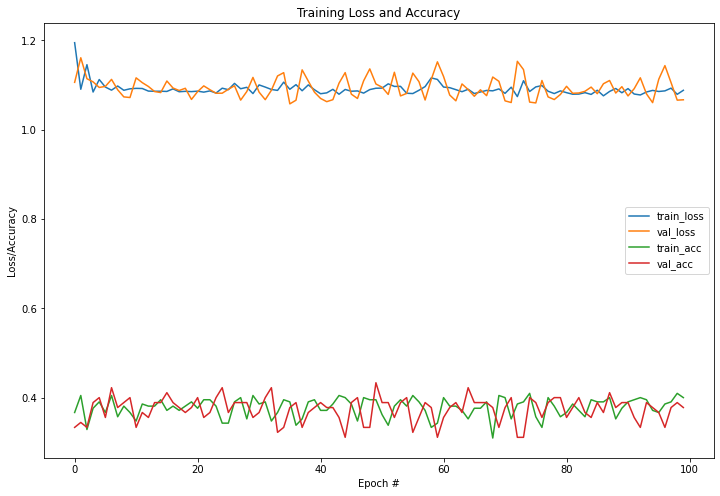

In [47]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

Normalized confusion matrix
[[17  0  6]
 [17  0 14]
 [19  0 17]]


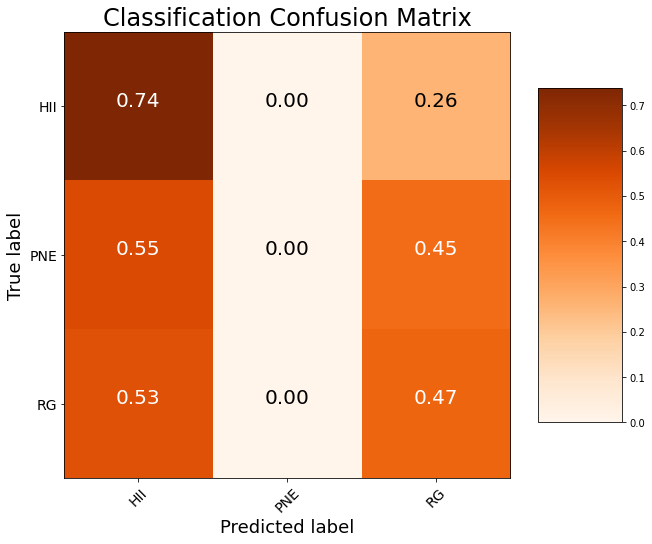

In [48]:
predictions_cm = np.argmax(predictionsANN,axis=1)

cmatrix = confusion_matrix(testLabels.argmax(axis=1), predictions_cm)
plot_confusion_matrix(cmatrix, classes = ['HII', 'PNE', 'RG'],
                      title = 'Classification Confusion Matrix', normalize=True)
print(cmatrix)

### Removing the momentum parameter from the optimiser:

In [49]:
model = Sequential() #Sequential is the model, so defining it in a variable so we can use it later.

model.add(Dense(256, input_shape=(32761,), activation="sigmoid"))
#Sigmoid activates the layer.
#first parameter of Dense() is the nodes, we used these numbers in the lectorial. Second parameter is the shape of the image

model.add(Dense(128, activation="sigmoid"))#hidden layer

model.add(Dense(3, activation="softmax"))#first parameter is how many classifications we have. 
#we have three layers, one input layer, one hidden layer and one output layer. 


# ----------------------------------------

learnRate = 0.01 #one of the most important parameters to set in the model. 
#learnRate is for determining how much to change a weight to drive the loss function to a minimum. 
#higher it's set = faster the model runs, but less accurate it is. 

opt = SGD(learnRate) #used for optimising the model. 

# ----------------------------------------

model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])#compiling the model

epochs = 100 #number of runs the model does. The more epochs can cause overfit and too little epochs will be underfit. 

#applying the data to the model. 
H = model.fit(trainSet, trainLabels, validation_data=(testSet, testLabels),
              epochs=epochs, batch_size=64, verbose = 0)


#------------------------------------------
from sklearn.metrics import classification_report #prints a report of the model


#applying the model to all the test data to check how well it's performed. 
predictionsANN = model.predict(testSet)

# Print a formatted report
print(classification_report(testLabels.argmax(axis=1), 
                                                  
                            predictionsANN.argmax(axis=1), 
                            target_names=[str(x) for x in lb.classes_]))#sets the labels for each output
                                                                        



3/3 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

         HII       0.33      0.74      0.45        23
         PNE       0.62      0.16      0.26        31
          RG       0.53      0.44      0.48        36

    accuracy                           0.42        90
   macro avg       0.50      0.45      0.40        90
weighted avg       0.51      0.42      0.40        90



In [50]:
from sklearn.metrics import confusion_matrix
import itertools

#plotting the confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges): #the required parameters for the confusion matrix function

    
#_____________________________________________________________________
# This is run only if the 'normalize' parameter is set to true.
    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm) #this prints the values that would be in the confusion matrix. 

#_____________________________________________________________________
#plotting the CM
    plt.figure(figsize = (10, 10)) #figure size
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #shows the image instead of printing it
    
    plt.title(title, size = 24) #setting the title of the plot, with font size. 
    
    plt.colorbar(aspect=4) #including a colour bar
    
    tick_marks = np.arange(len(classes)) #declaring a variable for number of ticks on both axes
    
    plt.xticks(tick_marks, classes, rotation=45, size = 14) #ticks on axes with size and angle. 
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

#_____________________________________________________________________
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
#    plt.grid(None)
#    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

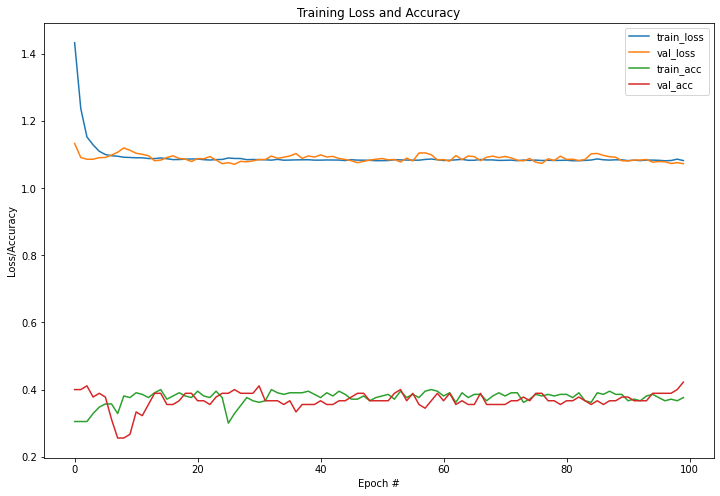

In [51]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

Normalized confusion matrix
[[17  2  4]
 [16  5 10]
 [19  1 16]]


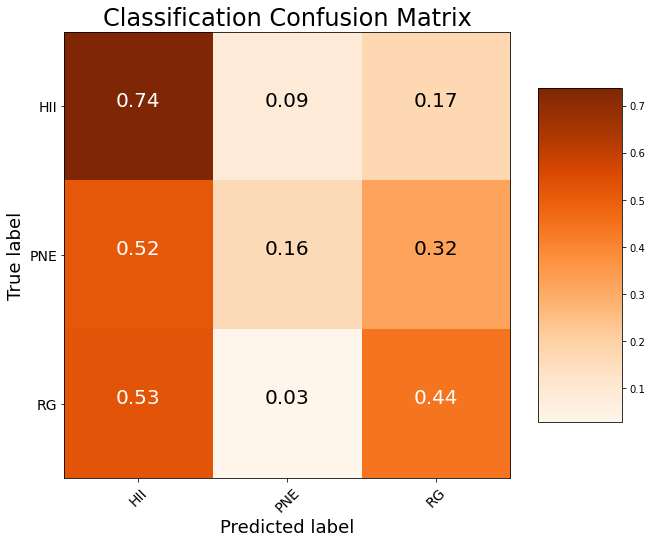

In [52]:
predictions_cm = np.argmax(predictionsANN,axis=1)

cmatrix = confusion_matrix(testLabels.argmax(axis=1), predictions_cm)
plot_confusion_matrix(cmatrix, classes = ['HII', 'PNE', 'RG'],
                      title = 'Classification Confusion Matrix', normalize=True)
print(cmatrix)

### Notes 

For both instances of changing the momentum value, there is high loss and low prediction values. 

Having momentum set to default smoothes the change in the loss function.

## Quantifying the performance

<font color='red'>Once your model is trained, run a few predictions using the test data and compare with the known label. Then, produce a classification report using the test data. Using the saved history from your model fit, plot on separate graphs the evolution of the Training and Testing/Validation loss and the evolution of the Training and Testing/Validation accuracy. You can also use the plotting code from [lectorial in week 8](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/Solution_Notebooks/ASTR3110_Tutorial_8_Random_Forest.ipynb) to produce a confusion matrix to help assess the classifier. Based on the outputs of the classification report and the plots, assess the performance of the classifier.</font>

Making a function. Noting that we will only allow the following for the exploration:

- 2 times the number of layers
- 2 times the number of neurons.
- half the number of neurons.

In [53]:
trainData, testData, trainLabels, testLabels = train_test_split(pixelValues, binarizedLabels, test_size=0.3)

In [54]:
def annFn(extraLayers : int, neurons: float, learnRate: float, epochs: int, momentum: float):
  '''
  
  extraLayers == 0, 1 or 2

  neurons == 0.5, 1.0, 2.0


  '''

  model = Sequential()
  
  model.add(Dense(256*neurons, input_shape=(32761,), activation="sigmoid"))

  model.add(Dense(128*neurons, activation="sigmoid"))
  
  if extraLayers == 1:
    model.add(Dense(128*neurons, activation="sigmoid"))
  
  if extraLayers == 2: 
    model.add(Dense(128*neurons, activation="sigmoid"))
    model.add(Dense(128*neurons, activation="sigmoid"))

  model.add(Dense(3, activation="softmax"))

  # ----------------------------------------

  opt = SGD(learnRate, momentum = momentum)

  # ----------------------------------------

  model.compile(loss="categorical_crossentropy", optimizer=opt,
                metrics=["accuracy"])

  H = model.fit(trainData, trainLabels, validation_data=(testData, testLabels),
                epochs= epochs, batch_size=64, verbose = 0)

  predictions = model.predict(testData)
  # print(predictions)
  print(classification_report(testLabels.argmax(axis=1), predictions.argmax(axis=1), target_names=[str(x) for x in lb.classes_]))

  def lossAccHistory(H):
      fig, (ax1, ax2) = plt.subplots(1,2,figsize=(24,8)) # Subplots

      # Loss function curves against the number of epochs:
      ax1.plot(np.arange(0, epochs), H["loss"], label="train_loss")
      ax1.plot(np.arange(0, epochs), H["val_loss"], label="val_loss")
      ax1.title.set_text('Training and Validation Loss')
      ax1.set_xlabel('Epoch Number')
      ax1.set_ylabel('Loss')
      ax1.legend(loc='best')

      # Accuracy curves against the number of epochs:
      ax2.plot(np.arange(0, epochs), H["accuracy"], label="train_acc")
      ax2.plot(np.arange(0, epochs), H["val_accuracy"], label="val_acc")
      ax2.title.set_text('Training and Validation Accuracy')
      ax2.set_xlabel('Epoch Number')
      ax2.set_ylabel('Accuracy')
      ax2.legend(loc='best')

  lossAccHistory(H.history)


  testY = np.argmax(testLabels,axis=1)
  predictY = np.argmax(predictions, axis=1)

  cm = confusion_matrix(testY, predictY)
  #call the function above that makes the plot, with given matrix and the labels required
  plot_confusion_matrix(cm, normalize=True,classes = ['HII', 'PNE', 'RG'],
                        title = 'Confusion Matrix')

Using the same hyperparameters as before to ensure the function works.

3/3 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

         HII       0.76      0.81      0.78        31
         PNE       0.57      0.70      0.63        30
          RG       0.85      0.59      0.69        29

    accuracy                           0.70        90
   macro avg       0.73      0.70      0.70        90
weighted avg       0.72      0.70      0.70        90

Normalized confusion matrix


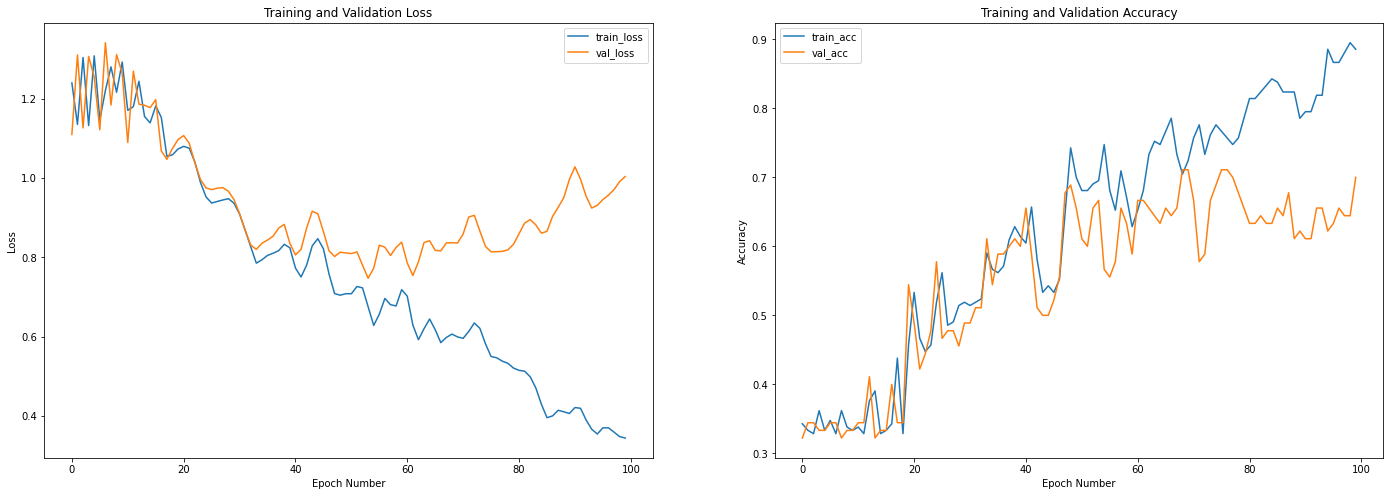

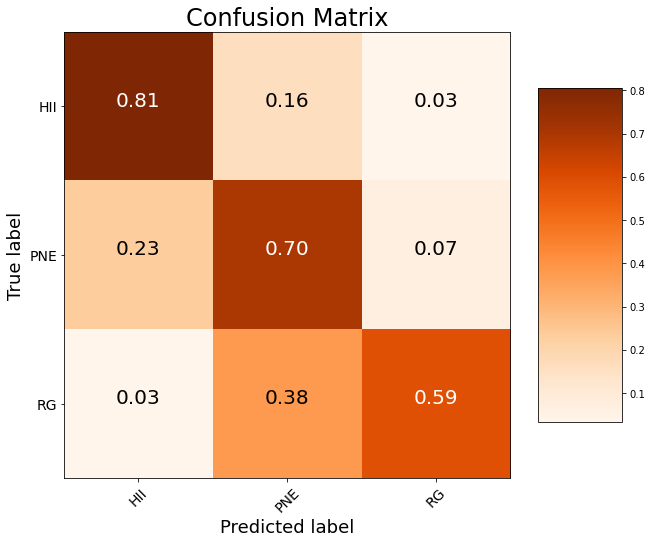

In [55]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 100, momentum = 1.0)

## Tweak the hyperparameters to improve performance
<font color='red'>


Try to improve your classifier by changing the following:

- The learning rate and number of epochs (smaller learning rate generally requires more training epochs and vice versa).
- The number of hidden layers (only try 1-2 fewer/more).
- The number of neurons in the layers (again, only try 1-2 different values).

For each tweak, run the classification reports, generate a confusion matrix, and produce plots of the history of the Loss and Accuracy and give a brief assessment of the performance. 

Finally, give a summary report for the best classifier achieved, and outline which of the changes was the most effective.</font>

### Tweaking learn rate, number of epochs and momentum

Performing the following: 

Round 1
- 100, 0.01, 1.0
- 100, 0.005, 1.0
- 100, 0.005, 0.9
- 100, 0.01, 0.9

then round 2
- 200, 0.01, 1.0
- 200, 0.005, 1.0
- 200, 0.005, 0.9
- 200. 0.01, 0.9

then round 3
- 600, 0.01, 1.0
- 600, 0.005, 1.0
- 600, 0.005, 0.9 
- 600, 0.01, 0.9

#### Round 1

*Error with prediction of certain objects due to low number of epochs (only sometimes?).

Decreasing learn rate prevented underfitting (loss and accuracy functions converge)

Decreasing momentum reduced fluctuation in loss function

The final tweak in this round saw the best results. Convergence between the loss functions, best minimisation of the loss functions and highest accuracies with no divergence. Predictions for this tweak had acceptable results for HII and RG, ~0.5 for PNE. 

*

3/3 [==============================] - 0s 26ms/step
              precision    recall  f1-score   support

         HII       0.76      0.81      0.78        31
         PNE       0.51      0.60      0.55        30
          RG       0.73      0.55      0.63        29

    accuracy                           0.66        90
   macro avg       0.67      0.65      0.65        90
weighted avg       0.67      0.66      0.66        90

Normalized confusion matrix


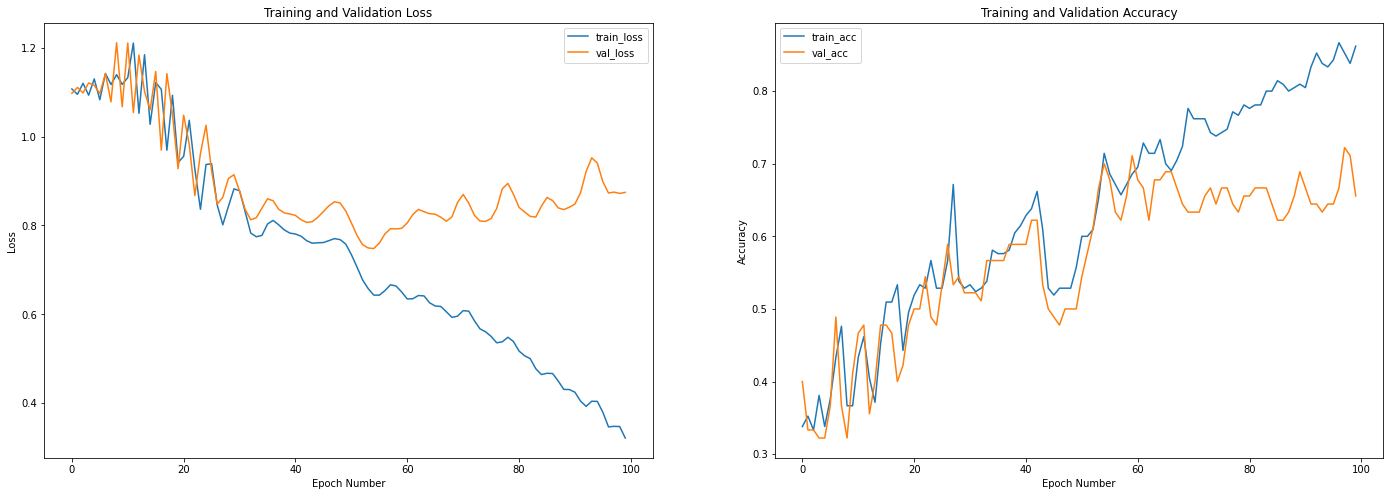

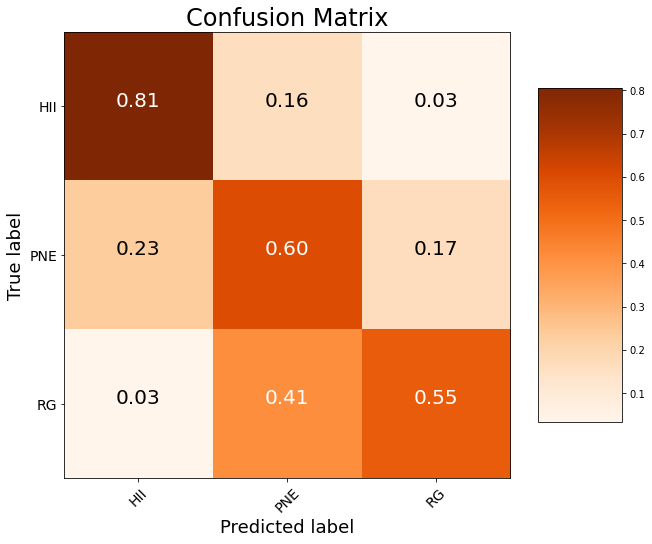

In [56]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 100, momentum = 1.0)

3/3 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

         HII       0.73      0.77      0.75        31
         PNE       0.54      0.23      0.33        30
          RG       0.61      0.93      0.74        29

    accuracy                           0.64        90
   macro avg       0.63      0.65      0.61        90
weighted avg       0.63      0.64      0.61        90

Normalized confusion matrix


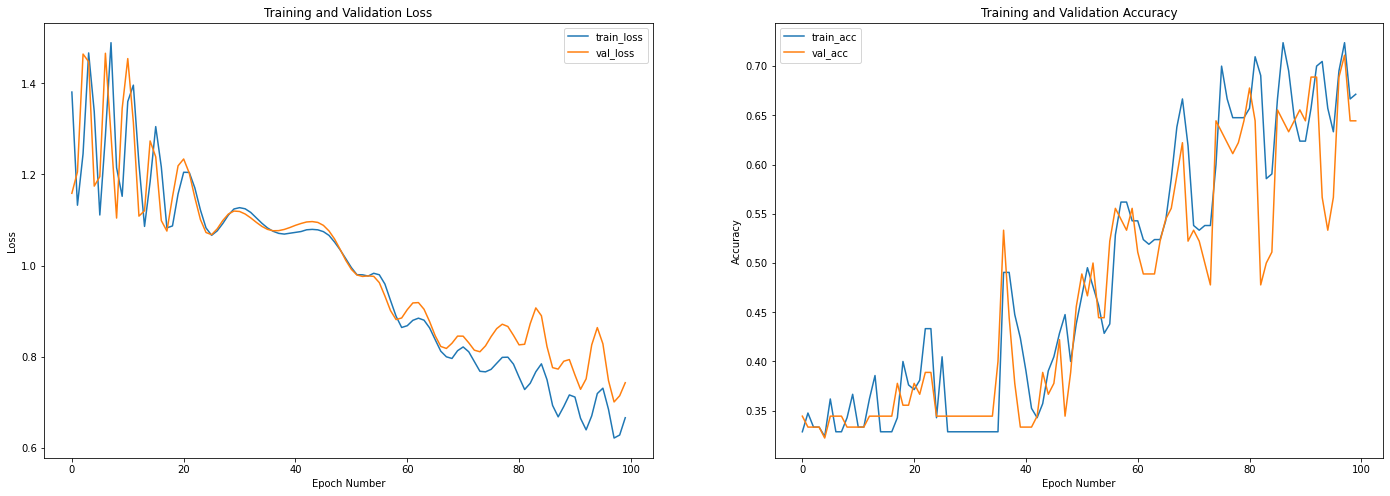

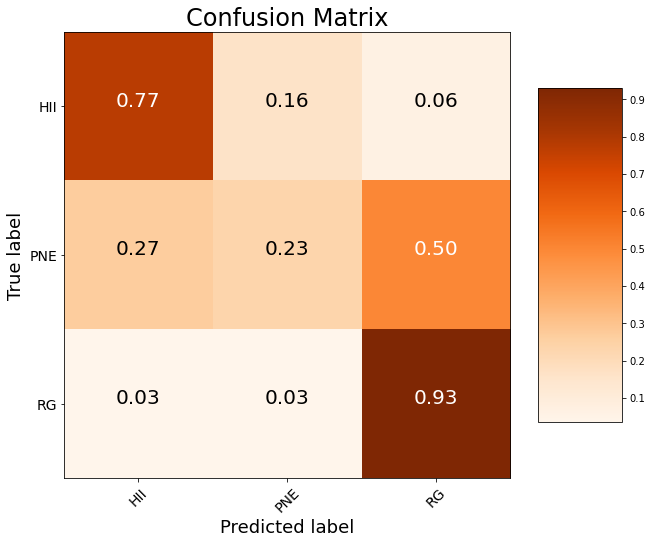

In [57]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.005, epochs = 100, momentum = 1.0)

3/3 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

         HII       0.86      0.61      0.72        31
         PNE       1.00      0.10      0.18        30
          RG       0.45      1.00      0.62        29

    accuracy                           0.57        90
   macro avg       0.77      0.57      0.51        90
weighted avg       0.77      0.57      0.51        90

Normalized confusion matrix


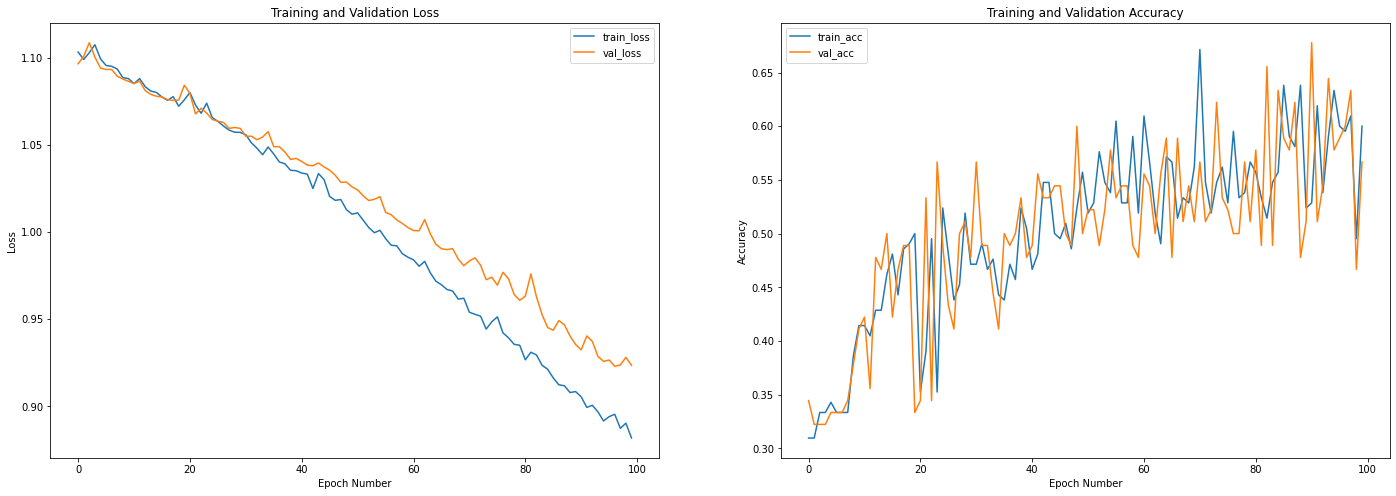

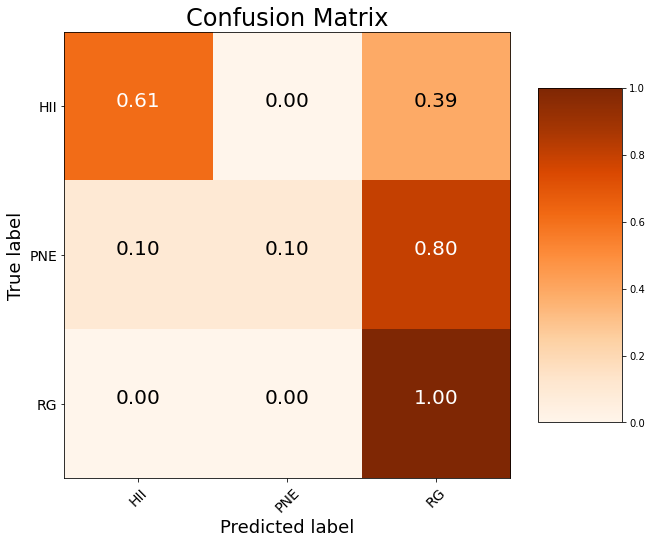

In [58]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.005, epochs = 100, momentum = 0.9)

3/3 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

         HII       0.87      0.65      0.74        31
         PNE       0.48      0.43      0.46        30
          RG       0.62      0.86      0.72        29

    accuracy                           0.64        90
   macro avg       0.66      0.65      0.64        90
weighted avg       0.66      0.64      0.64        90

Normalized confusion matrix


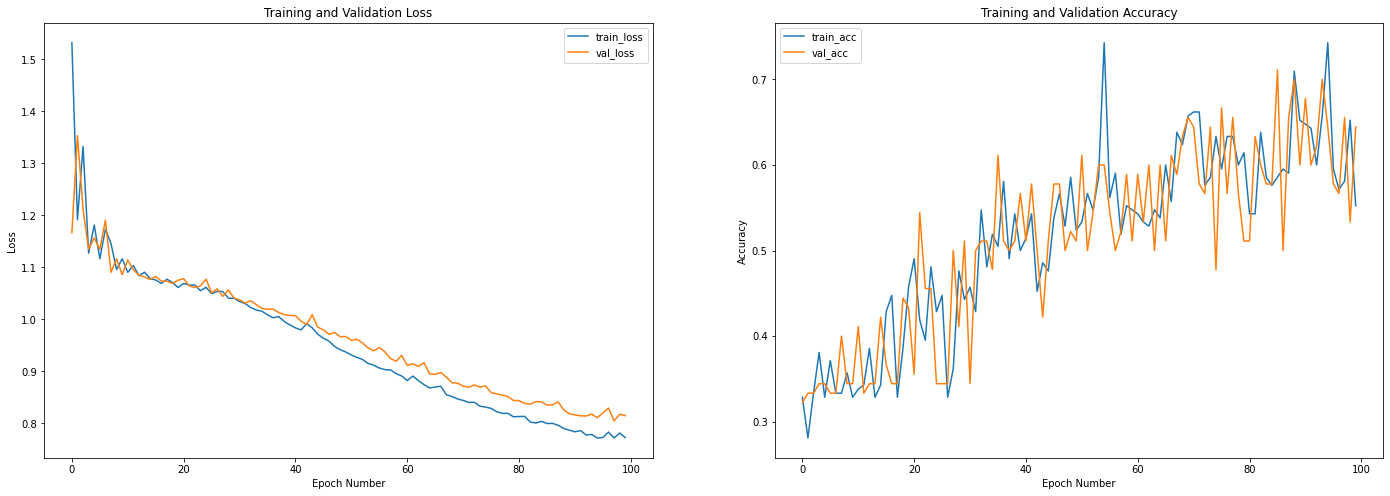

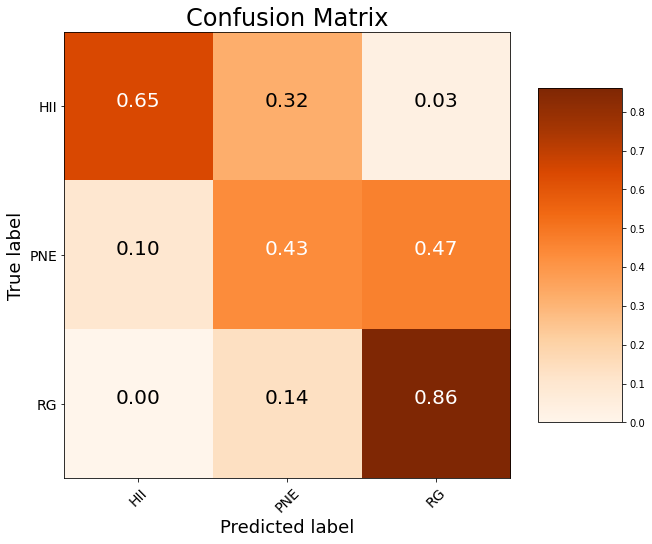

In [59]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 100, momentum = 0.9)

####  Round 2

*Similar to round 1, decreasing learn rate and momentum reduced fluctation in the loss functions and prevented divergence between the loss functions. *

*In this round, all these tweaks cause underfitting around 100 epochs. 200 epochs is not an option.*

3/3 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

         HII       0.79      0.71      0.75        31
         PNE       0.57      0.67      0.62        30
          RG       0.78      0.72      0.75        29

    accuracy                           0.70        90
   macro avg       0.71      0.70      0.70        90
weighted avg       0.71      0.70      0.70        90

Normalized confusion matrix


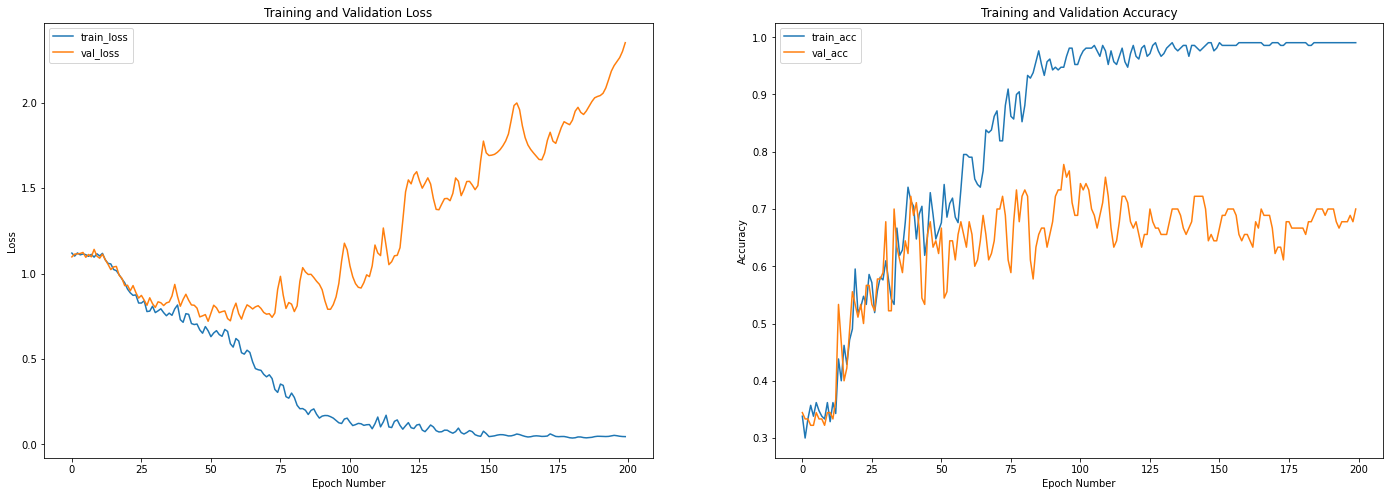

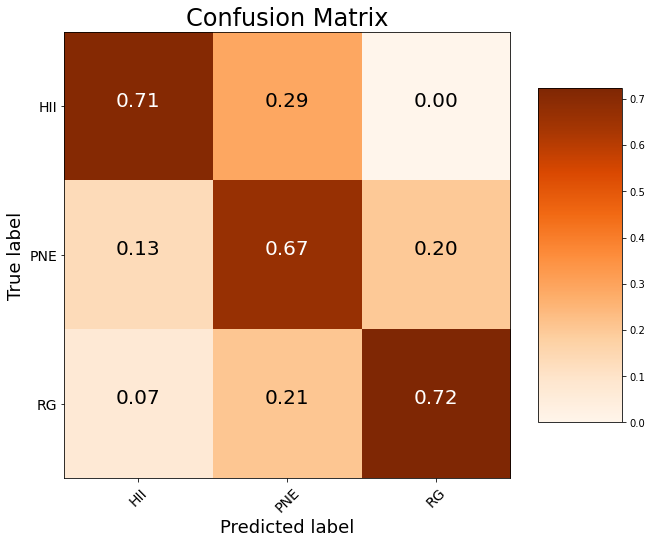

In [61]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 200, momentum = 1.0)

3/3 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

         HII       0.78      0.68      0.72        31
         PNE       0.53      0.63      0.58        30
          RG       0.70      0.66      0.68        29

    accuracy                           0.66        90
   macro avg       0.67      0.66      0.66        90
weighted avg       0.67      0.66      0.66        90

Normalized confusion matrix


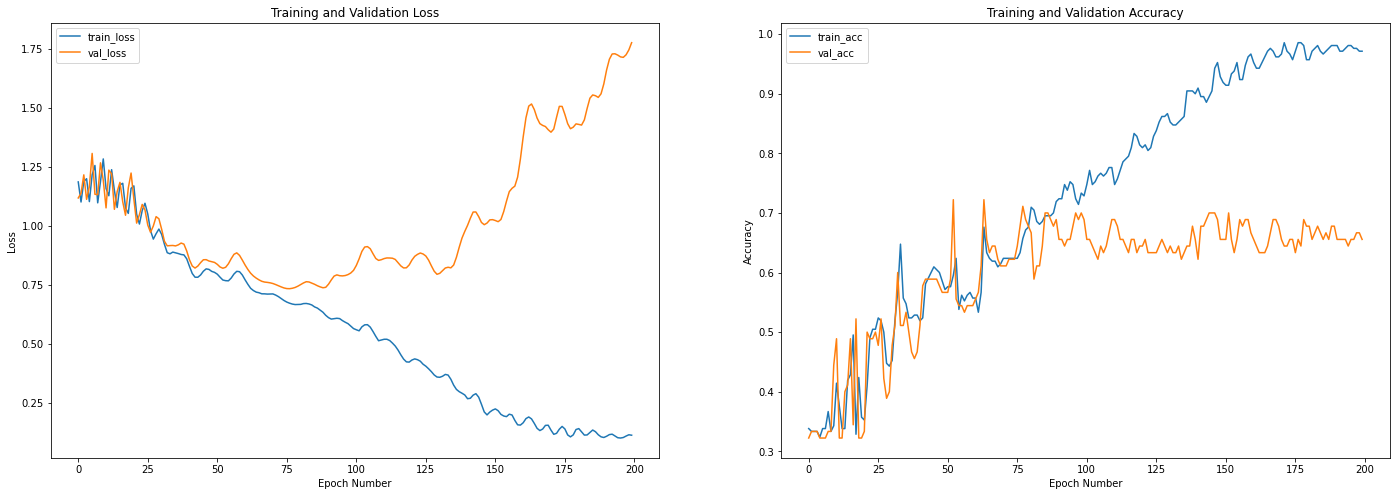

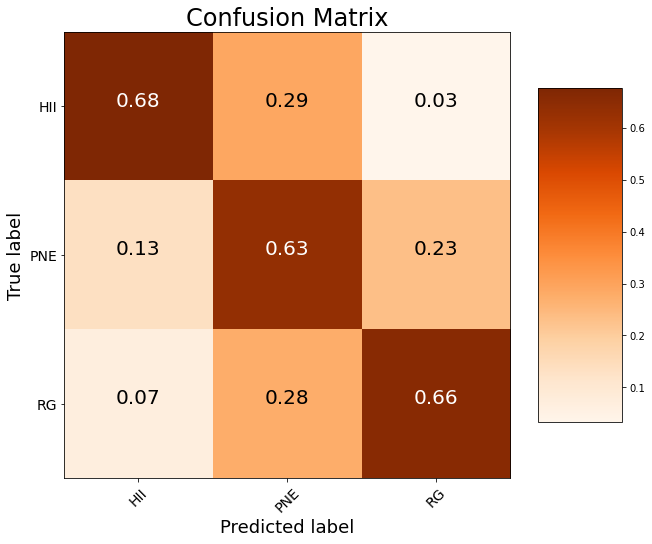

In [62]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.005, epochs = 200, momentum = 1.0)

3/3 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

         HII       0.79      0.71      0.75        31
         PNE       0.62      0.17      0.26        30
          RG       0.52      0.97      0.67        29

    accuracy                           0.61        90
   macro avg       0.64      0.61      0.56        90
weighted avg       0.65      0.61      0.56        90

Normalized confusion matrix


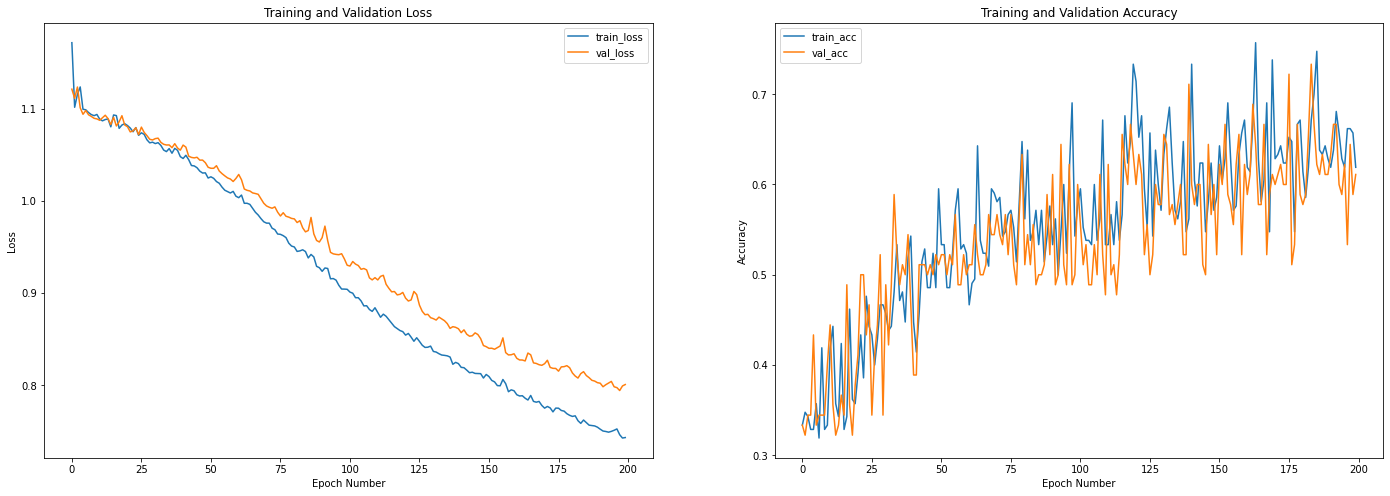

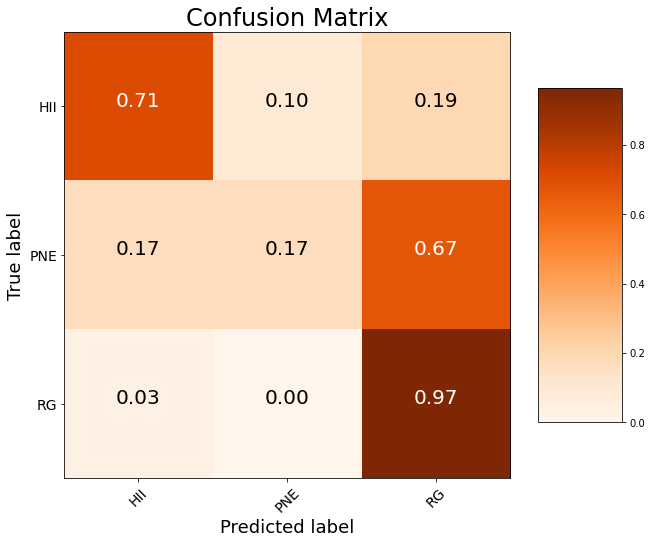

In [63]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.005, epochs = 200, momentum = 0.9)

3/3 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

         HII       0.83      0.65      0.73        31
         PNE       0.52      0.43      0.47        30
          RG       0.63      0.90      0.74        29

    accuracy                           0.66        90
   macro avg       0.66      0.66      0.65        90
weighted avg       0.66      0.66      0.65        90

Normalized confusion matrix


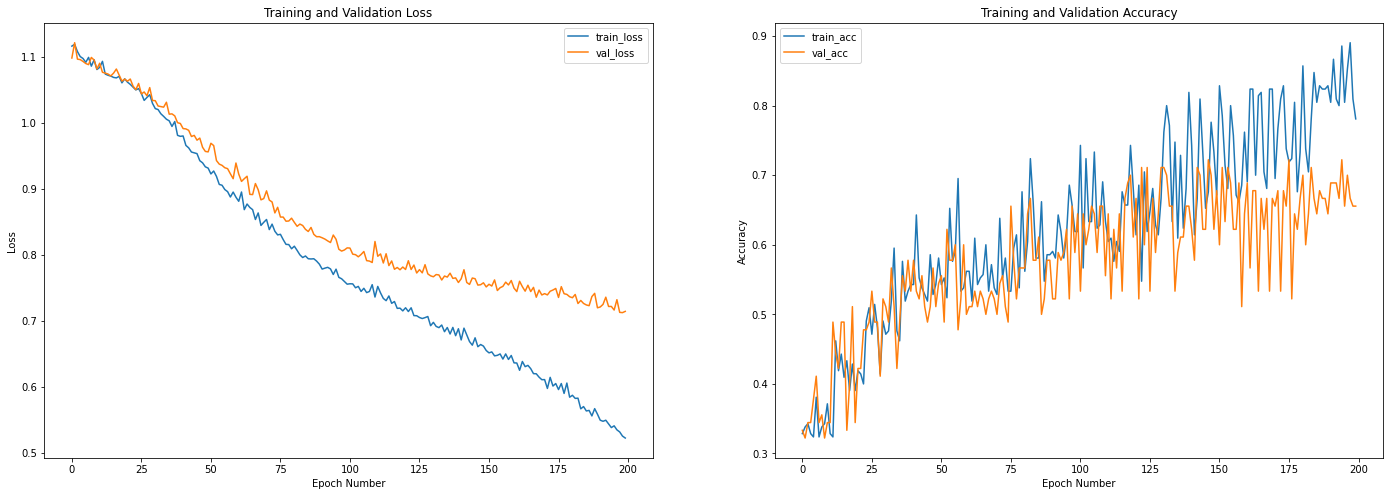

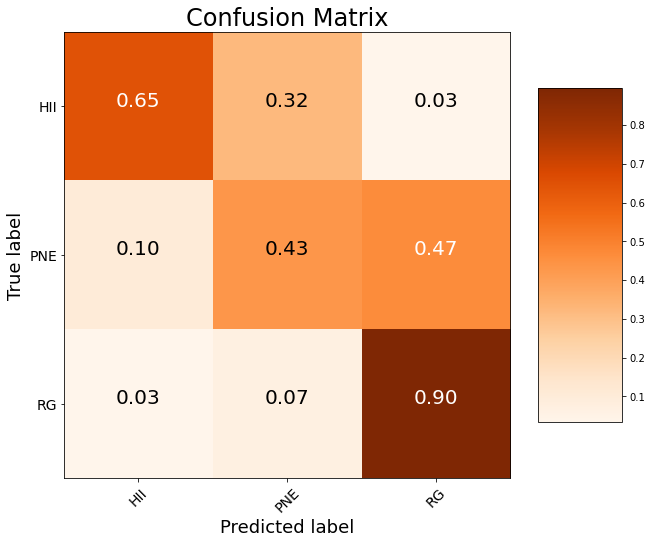

In [64]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 200, momentum = 0.9)

#### Round 3
*All tweaks in this round had poor results. Primarily due to underfitting occuring after 100 epochs.*

3/3 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

         HII       0.70      0.68      0.69        31
         PNE       0.47      0.63      0.54        30
          RG       0.70      0.48      0.57        29

    accuracy                           0.60        90
   macro avg       0.62      0.60      0.60        90
weighted avg       0.62      0.60      0.60        90

Normalized confusion matrix


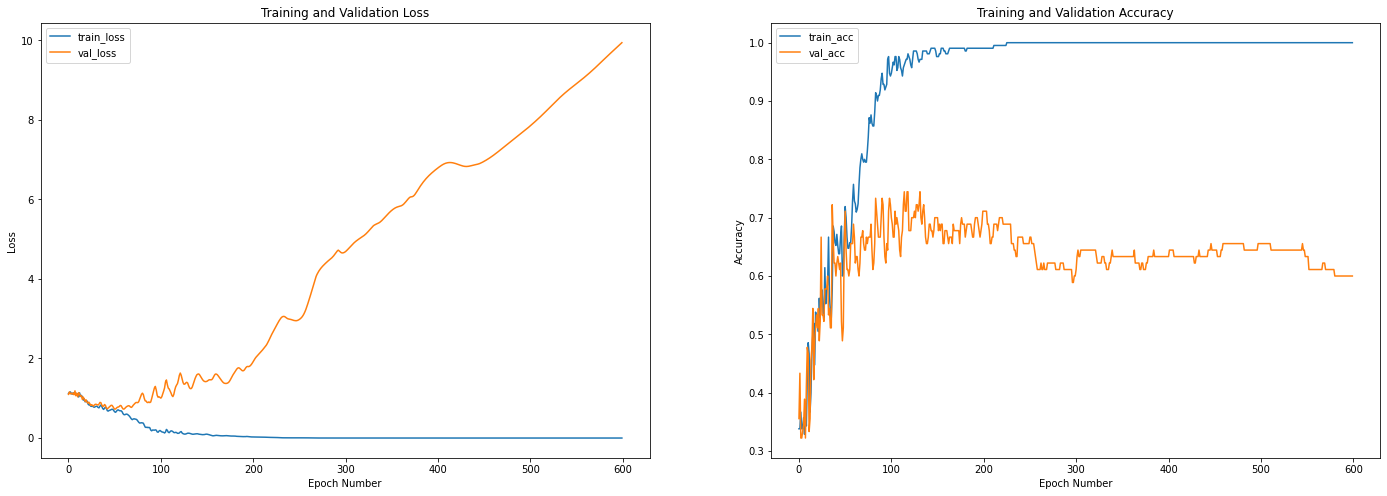

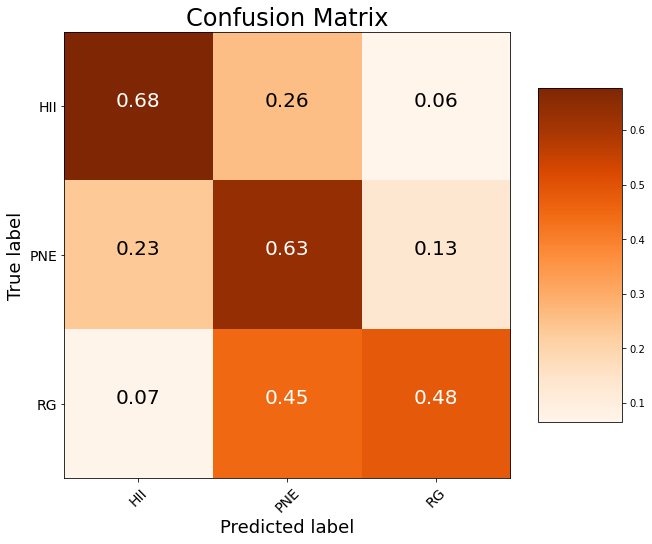

In [65]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 600, momentum = 1.0)

3/3 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

         HII       0.65      0.77      0.71        31
         PNE       0.34      0.47      0.39        30
          RG       0.58      0.24      0.34        29

    accuracy                           0.50        90
   macro avg       0.52      0.49      0.48        90
weighted avg       0.53      0.50      0.48        90

Normalized confusion matrix


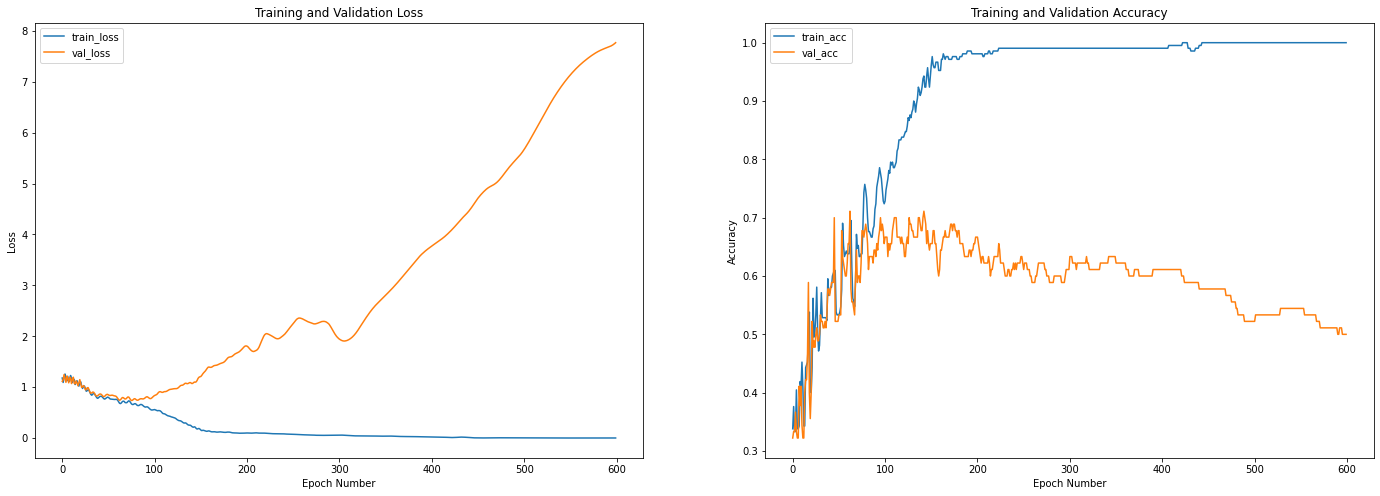

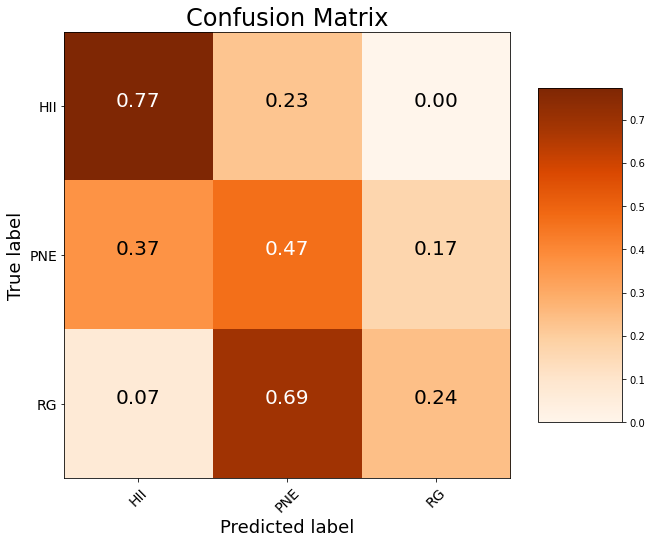

In [66]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.005, epochs = 600, momentum = 1.0)

3/3 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

         HII       0.87      0.65      0.74        31
         PNE       0.58      0.63      0.60        30
          RG       0.71      0.83      0.76        29

    accuracy                           0.70        90
   macro avg       0.72      0.70      0.70        90
weighted avg       0.72      0.70      0.70        90

Normalized confusion matrix


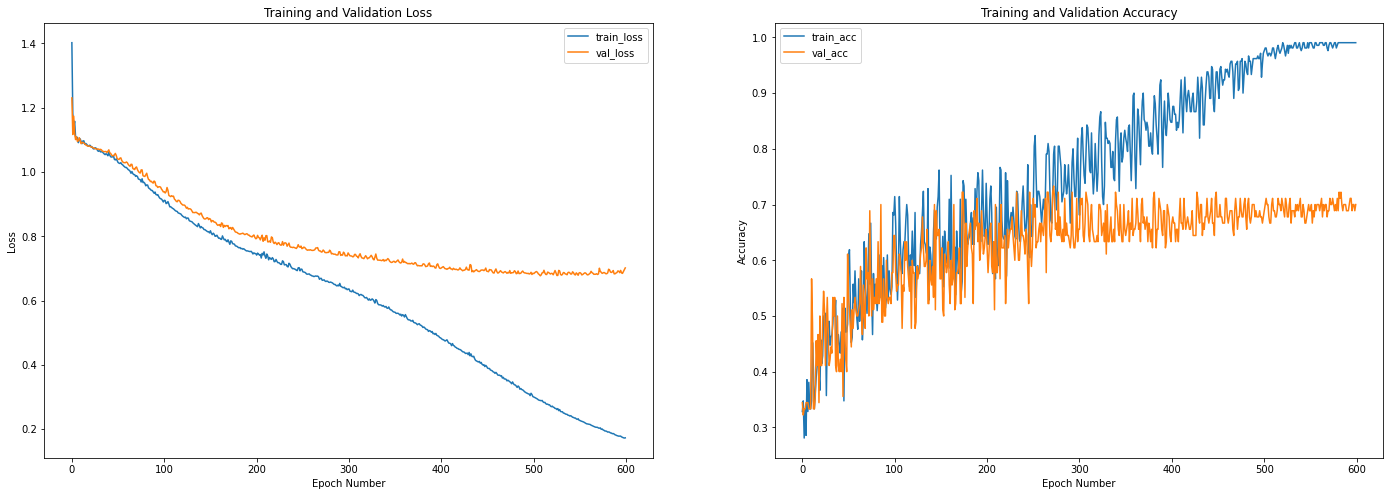

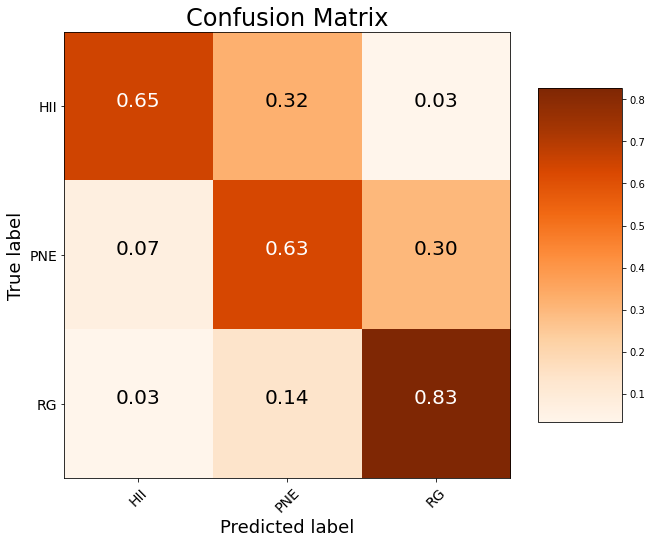

In [67]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.005, epochs = 600, momentum = 0.9)

3/3 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

         HII       0.91      0.68      0.78        31
         PNE       0.61      0.63      0.62        30
          RG       0.69      0.86      0.77        29

    accuracy                           0.72        90
   macro avg       0.74      0.72      0.72        90
weighted avg       0.74      0.72      0.72        90

Normalized confusion matrix


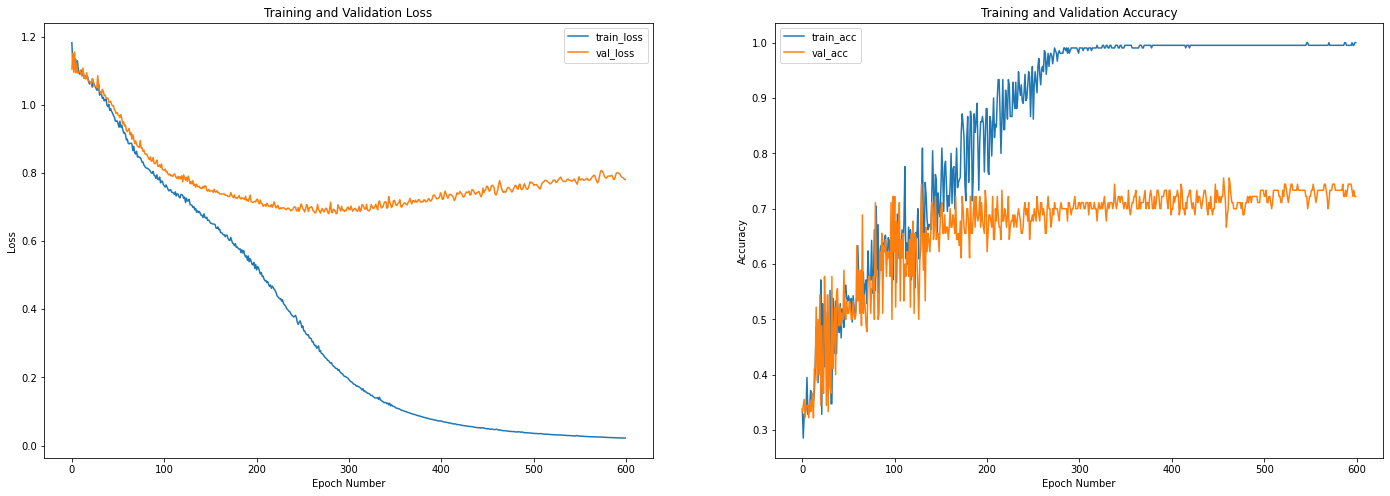

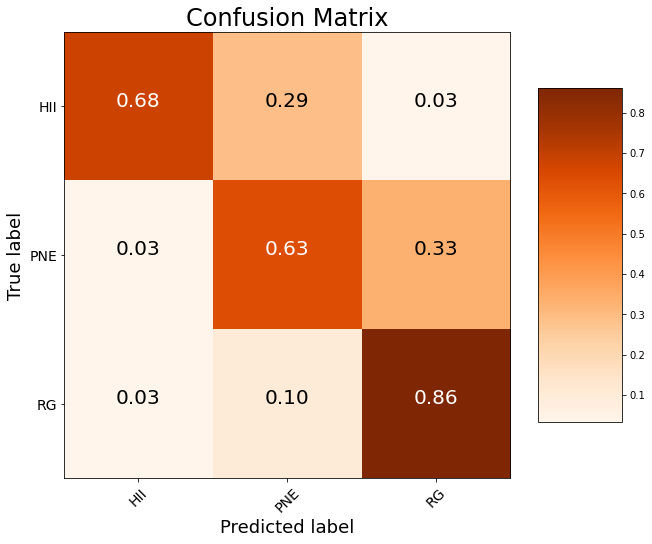

In [68]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 600, momentum = 0.9)

### Tweaking the number of layers and neurons based on the best performance from the previous rounds.

Should we perform the same number of tweaks in the previous rounds for the new number of layers and neurons?

Performing the following with 100 epochs, 0.01 learning rate, 0.9 momentum: 

Round 4

- 1 extra layer, default neurons (1.0)
- 1 extra layer, double neurons
- 1 extra layer, half the neurons

Round 5
- 2 extra layers, default neurons
- 2 extra layers, double neurons
- 2 extra layers, half neurons

#### Round 4
*Overall poor performance, loss functions converge but low minimisation achieved. Some predictions missing for objects.*

3/3 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

         HII       0.75      0.58      0.65        31
         PNE       0.39      0.87      0.54        30
          RG       0.00      0.00      0.00        29

    accuracy                           0.49        90
   macro avg       0.38      0.48      0.40        90
weighted avg       0.39      0.49      0.41        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


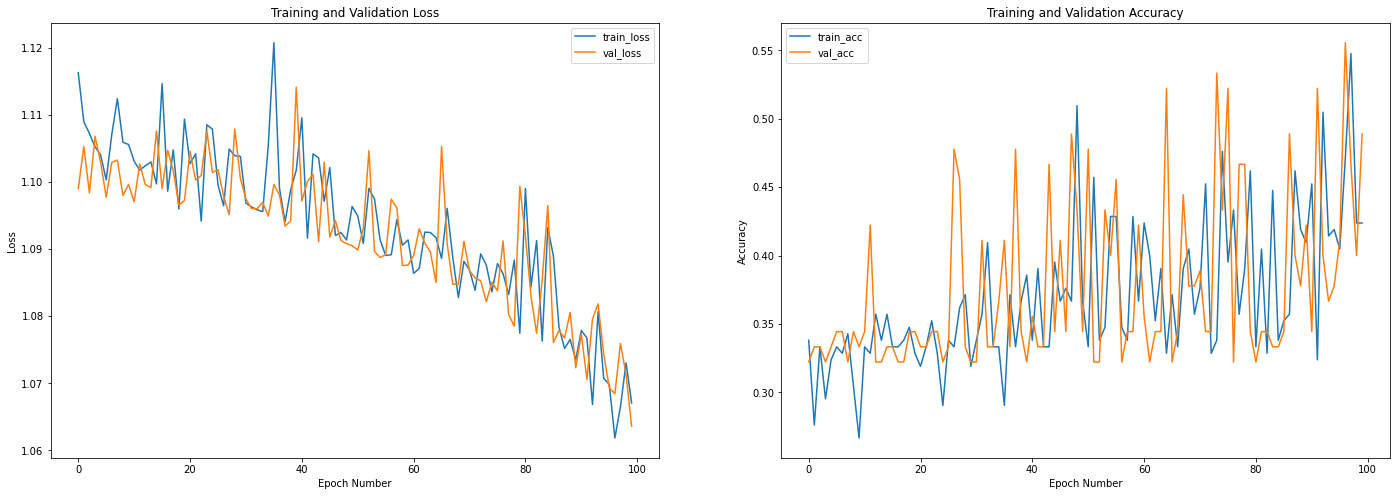

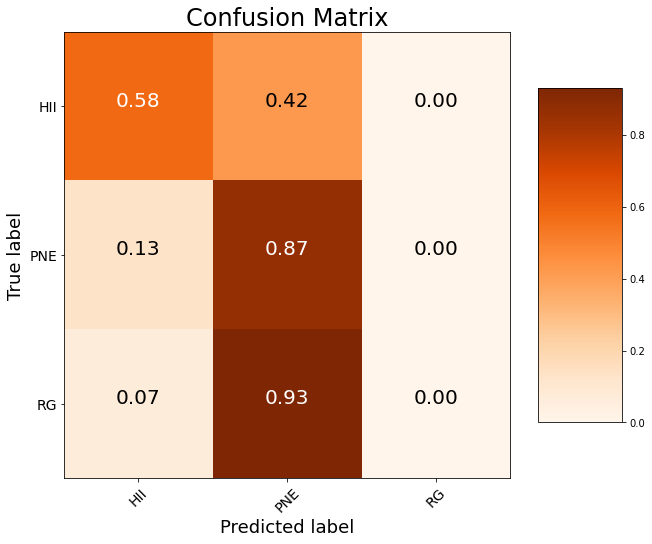

In [69]:
annFn(extraLayers = 1, neurons = 1.0, learnRate = 0.01, epochs = 100, momentum = 0.9)

3/3 [==============================] - 0s 36ms/step
              precision    recall  f1-score   support

         HII       0.34      1.00      0.51        31
         PNE       0.00      0.00      0.00        30
          RG       0.00      0.00      0.00        29

    accuracy                           0.34        90
   macro avg       0.11      0.33      0.17        90
weighted avg       0.12      0.34      0.18        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


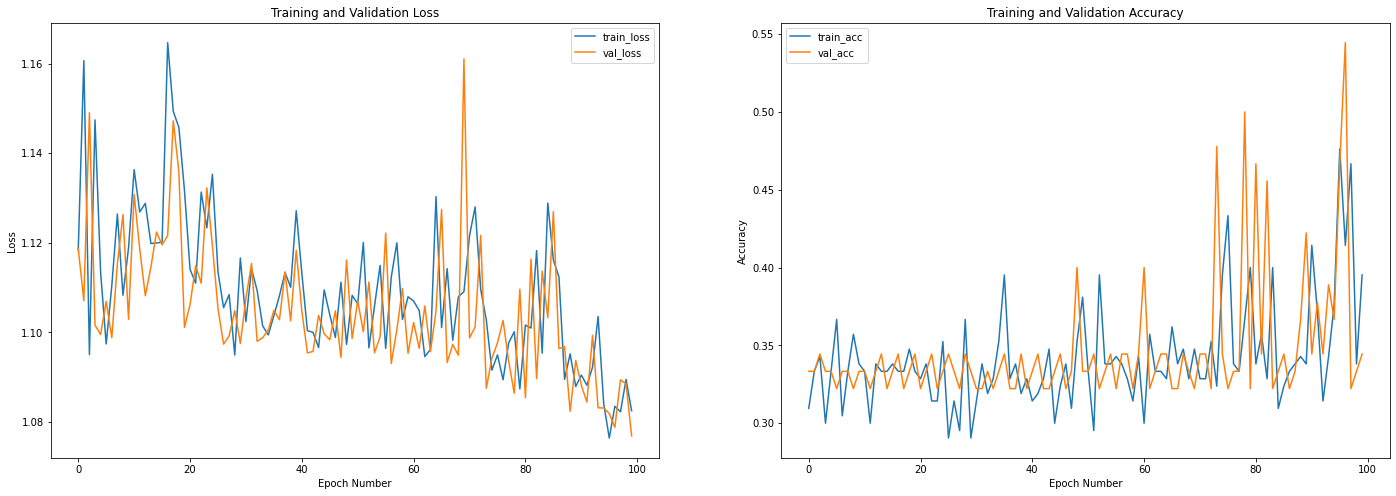

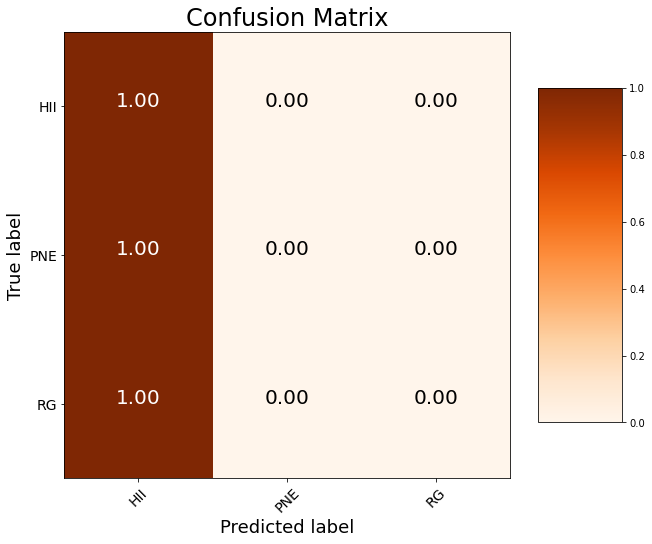

In [70]:
annFn(extraLayers = 1, neurons = 2.0, learnRate = 0.01, epochs = 100, momentum = 0.9)

3/3 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

         HII       1.00      0.23      0.37        31
         PNE       0.29      0.13      0.18        30
          RG       0.39      0.93      0.55        29

    accuracy                           0.42        90
   macro avg       0.56      0.43      0.37        90
weighted avg       0.57      0.42      0.37        90

Normalized confusion matrix


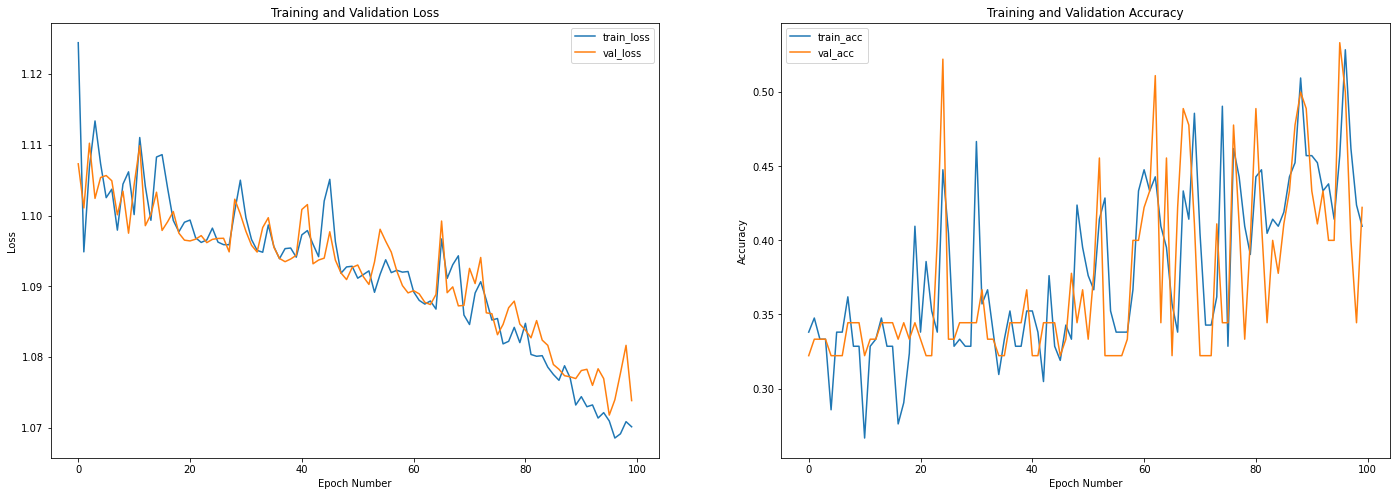

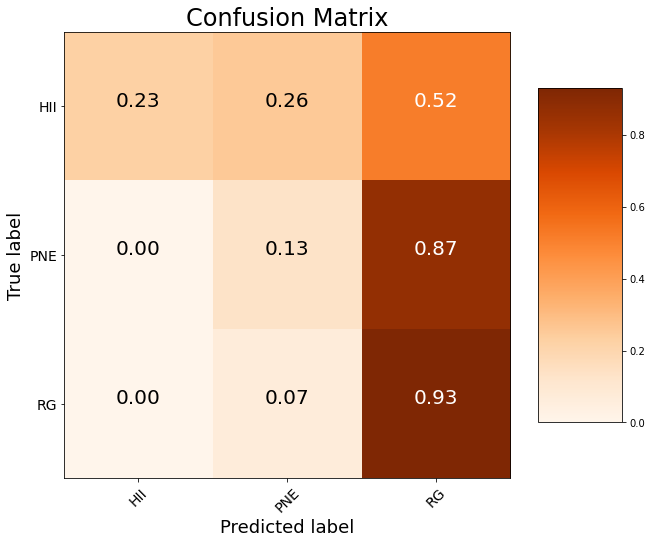

In [71]:
annFn(extraLayers = 1, neurons = 0.5, learnRate = 0.01, epochs = 100, momentum = 0.9)

#### Round 5
*Same as round 4, overall poor performance.*

3/3 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

         HII       0.34      1.00      0.51        31
         PNE       0.00      0.00      0.00        30
          RG       0.00      0.00      0.00        29

    accuracy                           0.34        90
   macro avg       0.11      0.33      0.17        90
weighted avg       0.12      0.34      0.18        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


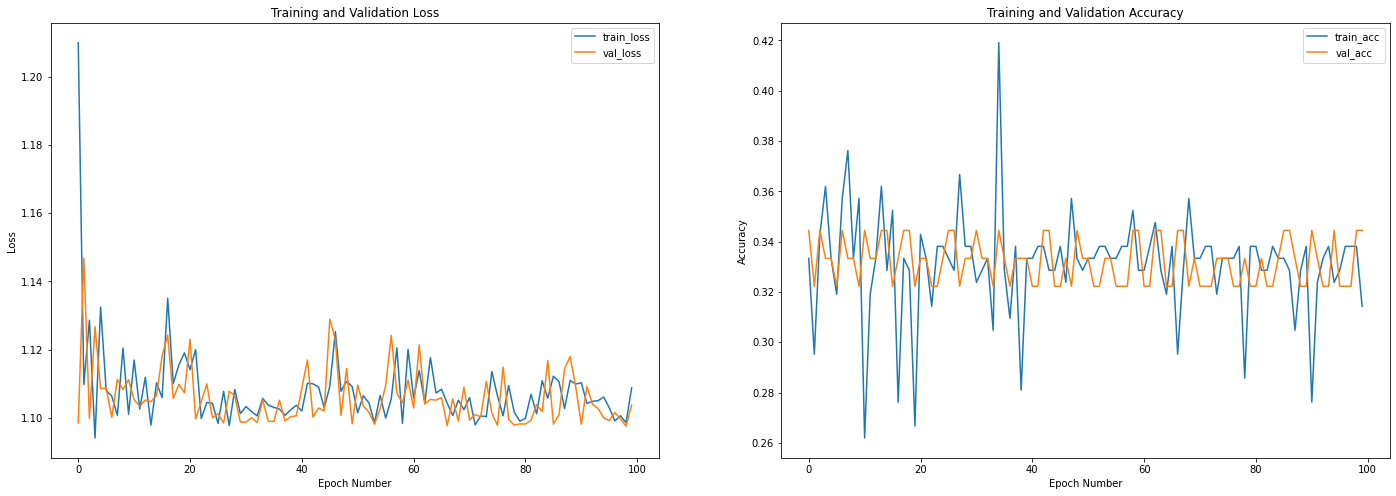

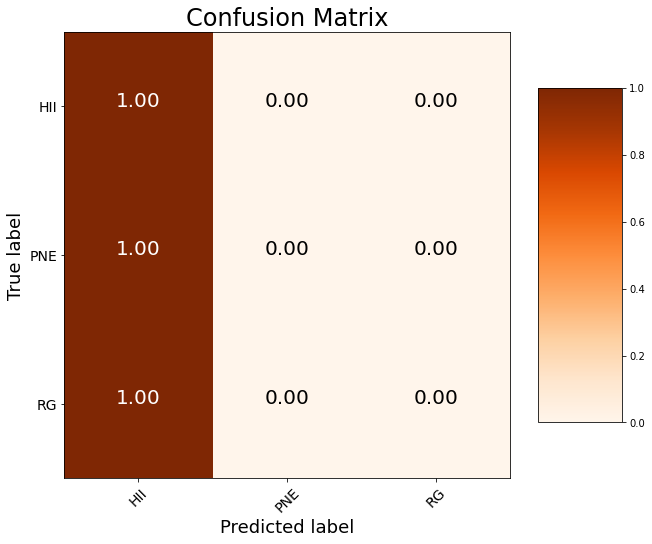

In [72]:
annFn(extraLayers = 2, neurons = 1.0, learnRate = 0.01, epochs = 100, momentum = 0.9)

3/3 [==============================] - 1s 46ms/step
              precision    recall  f1-score   support

         HII       0.00      0.00      0.00        31
         PNE       0.00      0.00      0.00        30
          RG       0.32      1.00      0.49        29

    accuracy                           0.32        90
   macro avg       0.11      0.33      0.16        90
weighted avg       0.10      0.32      0.16        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


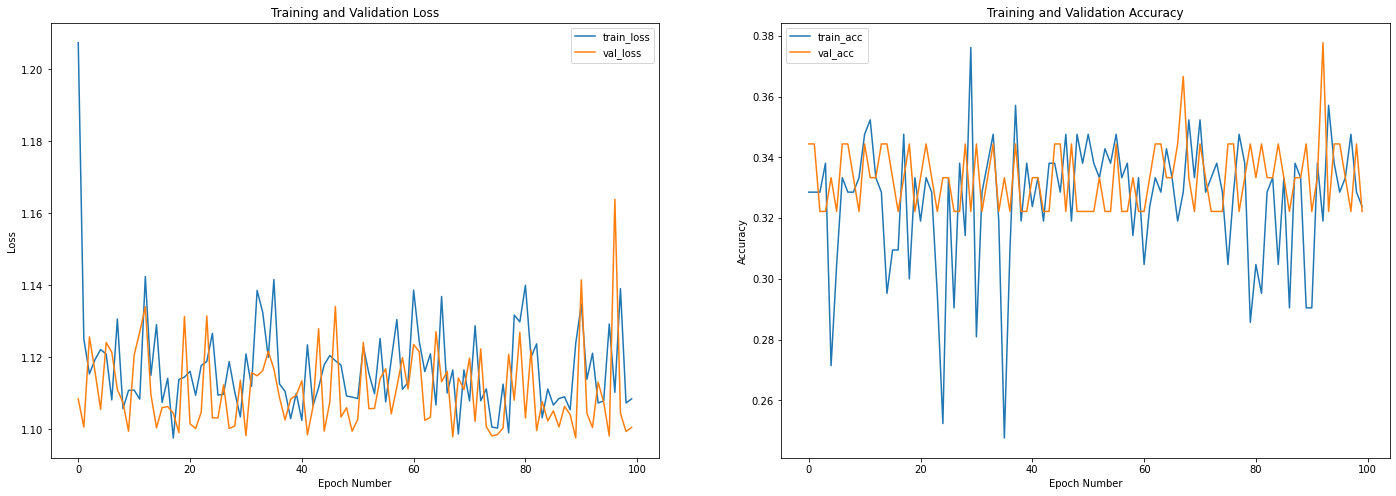

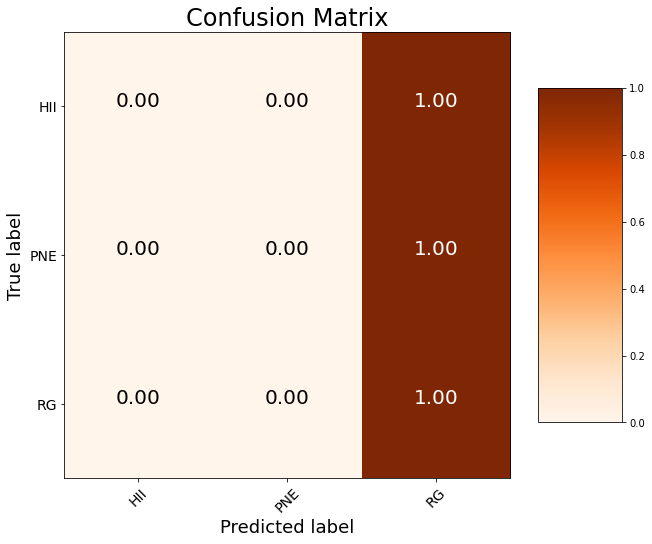

In [73]:
annFn(extraLayers = 2, neurons = 2.0, learnRate = 0.01, epochs = 100, momentum = 0.9)

3/3 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

         HII       0.00      0.00      0.00        31
         PNE       0.33      1.00      0.50        30
          RG       0.00      0.00      0.00        29

    accuracy                           0.33        90
   macro avg       0.11      0.33      0.17        90
weighted avg       0.11      0.33      0.17        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


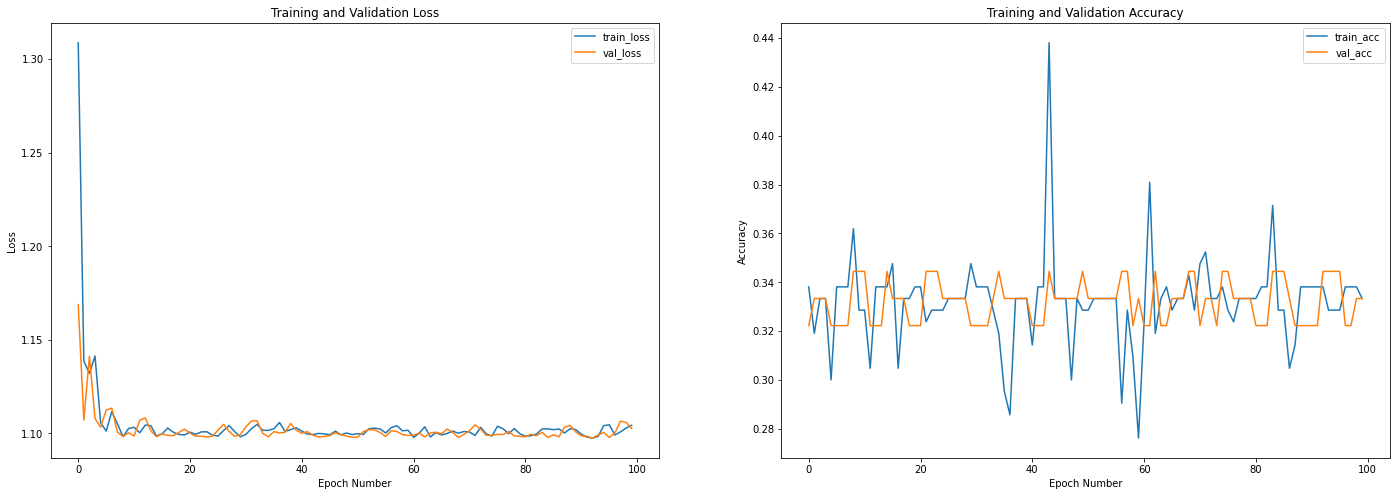

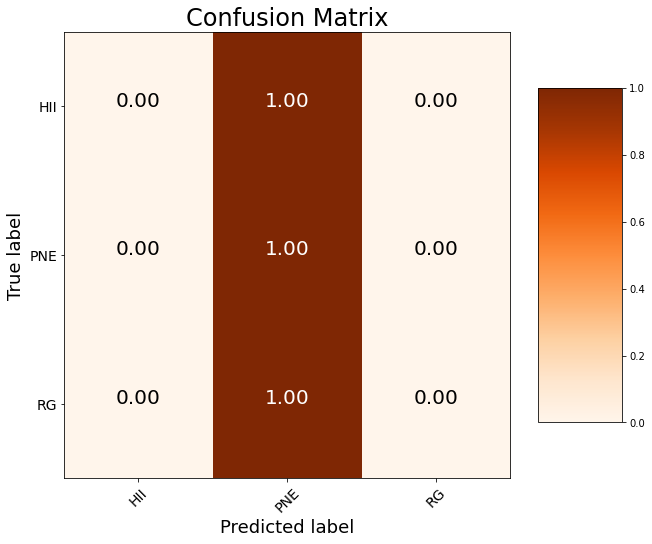

In [74]:
annFn(extraLayers = 2, neurons = 0.5, learnRate = 0.01, epochs = 100, momentum = 0.9)

### Final remarks

Considering how the loss functions in all the round 4 tweaks (not the round 5) show convergence and consistent decrease, we could try increasing the number of epochs as I mentioned in the begining of this subsection to see how the model performs with the one extra layer. However, for now we will continue to the CNN model. 

# Part 2: Convolutional Neural Networks

In this part, you will build a classifier for the same dataset, but now using all three Spitzer bands (I2 = 4.5 $\mu$m, I3 = 5.8 $\mu$m, I4 = 8 $\mu$m) as input to a CNN. 


## Preparing the data


As input, CNNs take a 4D array of images with shape (N_source, N_pix, N_pix, N_channel), where  N_source is the number of sources in your batch of data, N_pix is the number of pixels (can be different for width/height), and N_channel is the number of different colour images available per source (this could be RGB channels for standard images, but here it is the 3 Spitzer bands). As for the ANNs, we also require labels that have been binarized. You need to write a function similar to the one used to manipulate the data for the ANN, but modified to produce the desired input for the CNN:
- For each source, read and then resize the I2, I3, and I4 images. Stack to form an array with shape (N_pix, N_pix, N_channel).
- Normalise each image in the stack, but here we'd like to maintain the colour differences. So, determine the maximum  across all 3 images and use that as your nomalisation factor for all three images.

In a similar fashion to Part 1, you will need to loop over each source, read in the images, and save to a 4D array with shape (N_source, N_pix, N_pix, N_Channel).  Again, you will require a vector containing the labels for each source, as well as the binarized version. 

Once you have the array containing the images and the labels, split your data into a training and test/validation set.
</font>

in the lectorial, we had colours has RGB, but here we have different wavelengths of IR

CNN take array of shape: [N_source, N_pix, N_pix, N_channel]

### OLD

In [75]:
def globFnCNN(objectDir):
    fitsFileNames = glob.glob(root+data+objectDir+'\\*_I4.fits')
    return fitsFileNames

def readFileFnCNN(objectDir):
    
    files=(globFnCNN(objectDir))
    arrZeros= np.zeros((len(files),302,302,3))
    
    for i in range(len(files)):
#         print(files[-1])
#Currently, 'files' has all the I4 files in it. Following removes I4
        source= files[i].split('_I4.fits')[0]
#now we have all the I4 files without the I4 in their names. 
#We can now add the other channels into the one array: 
#         print(source)
        i4= fits.getdata(source+'_I4.fits')
        i3= fits.getdata(source+'_I3.fits')
        i2= fits.getdata(source+'_I2.fits')
        arrZeros[i,:,:,0]=i2
        arrZeros[i,:,:,1]=i3
        arrZeros[i,:,:,2]=i4
#we have take the files with no colour extension at the end of them, looked for their individual colour extensions, 
#added tem to their corresponding index in the arrZeros array.

    return arrZeros, files

In [76]:
hii = '\\HII'
pne = '\\PNE' 
rg = '\\RG'

hii_DF_raw, hii_files = readFileFnCNN(hii)
pne_DF_raw, pne_files = readFileFnCNN(pne)
rg_DF_raw, rg_files = readFileFnCNN(rg)

cnnDF = np.concatenate((hii_DF_raw, pne_DF_raw, rg_DF_raw))
cnnDF_fileNames = np.concatenate((hii_files, pne_files, rg_files))

In [ ]:
cnnDF.shape

(300, 302, 302, 3)

In [ ]:
maxValue = cnnDF.max()
maxValue

25802.8515625

for each colour, there are 100 files in each object, there are 3 objects. Totalling 900 files for all 3 colours and all objects. 


In [ ]:
#for iterating through the channels
arr3d = np.zeros(3)
#for storing the normed values.
arrZeros= np.zeros((300,302,302,3)) #To iterate through the entire cnnDF, all channels> all objects> all files. 
for j in range(len(arr3d)):
    for i in range(len(cnnDF)):
        #step 1
        arrZeros[i,:,:,j] = cnnDF[i,:,:,j]- cnnDF[i,:,:,j].min() #taking the min of each individual image.
        
        #step 2
        arrZeros[i,:,:,j] = arrZeros[i,:,:,j]/maxValue #applying the maxValue of cnnDF to each image
        
        #step 3, setting an appropriate name for the DF 
        cnnDF_norm = arrZeros
print(f'max {cnnDF_norm.max():.1f} and min {cnnDF_norm.min()}')

max 1.0 and min 0.0


In [ ]:
zoomFactor= (1,0.5,0.5,1)
cnnDF_zoom= ndimage.zoom(cnnDF_norm, zoomFactor)

Plotting to check if zoom worked

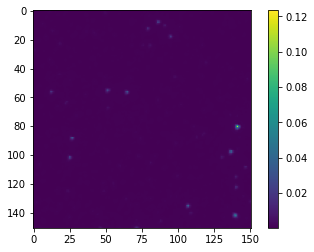

In [ ]:
plt.figure()
plt.imshow(cnnDF_zoom[0,:,:,0])
plt.colorbar()
# plt.title('hii original')

In [ ]:
cnnDF_zoom.shape

(300, 151, 151, 3)

don't have to reshape it because we want to keep the colours separate.

Creating an array for the labels

In [ ]:
labels = []

for i in range(len(cnnDF_fileNames)):
#     print(i)
    if 'HII' in cnnDF_fileNames[i]:
        labels.append(0)
#     if allFileNames[i]=='*PNE*' :
    if 'PNE' in cnnDF_fileNames[i]:
        labels.append(1)
#     if allFileNames[i]=='*RG*' :
    if 'RG' in cnnDF_fileNames[i]:
        labels.append(2)
        
cnnLabels= np.array(labels)
cnnLabels.shape

(300,)

Now we have the correct number of file names in an array. Splitting the data

In [ ]:
cnnDF_zoom.shape

(300, 151, 151, 3)

In [ ]:
cnnLabels.shape

(300,)

In [ ]:
cnnTrainData, cnnTestData, cnnTrainLabels, cnnTestLabels= train_test_split(cnnDF_zoom, cnnLabels, stratify= cnnLabels, test_size= 0.3, random_state= 42)

print('train_labels shape: ', cnnTrainLabels.shape, 'and test_labels shape: ', cnnTestLabels.shape)

lb = LabelBinarizer()

#converting our labels which contain 0,1,2 into one-hot vector format which is required for the binarizor function
cnnTrainLabels = lb.fit_transform(cnnTrainLabels)
cnnTestLabels = lb.transform(cnnTestLabels)

print('train_labels shape: ', cnnTrainLabels.shape, 'and test_labels shape: ', cnnTestLabels.shape)

train_labels shape:  (210,) and test_labels shape:  (90,)
train_labels shape:  (210, 3) and test_labels shape:  (90, 3)


DF is now split and we have our hot vectors. 

### HELP

## Running the CNN

With your data prepared, you can now start building your CNN. Start off by bulding a Sequential CNN with the same architecture, optimizer, and hyperparameters as that used in [Lectorial 10](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/Solution_Notebooks/ASTR3110_Tutorial_10_CNNs.ipynb), but modify the inputs so that they suit the data used here.

### OLD

In [ ]:
from keras.layers.convolutional import Conv2D #conv2d sets up layers

from keras.layers.convolutional import MaxPooling2D #bins the pixels of the images

from keras.layers.core import Flatten  #even though we haven't flattened our CNN data, the final layer requires flattened data

from keras.layers.core import Activation #neuron scaling

from keras.layers.core import Dropout #avoids overfitting by dropping a connection between dense layers. 
#introduces noise but prevents overfitting 

from keras import backend as K #computes complicated tensor operations. 

In [ ]:
#Now we can start to build our model.
# Initialize the model and channel order
model = Sequential()

#set up our input parameters
size= cnnTrainData.shape[1]#Images are same height and width, their size is located in this 1st index.
#If they werent, we would have to access the appropriate index for their corresponding sizes. 

inputShape = (size, size, 3) #shape of images, we have 3 colours represented in the last parameter. 

#double checking the module `backend`
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (3, size, size)
    chanDim = 1

In [ ]:
#starting with 3 layers. Input, hidden (dense) and the output (predicted classes) layer. 

#show the commented architecture first...

#_____________________________________________
#First layer
model.add(Conv2D(32, (3, 3), input_shape=inputShape)) #32 different neurons in the first (input) layer. Each neuron trained to 
#detect different features. Filter size is a 3x3 kernel

model.add(Activation('relu')) #Activation = sigmoid from ANN. Activates the layer.

model.add(MaxPooling2D(pool_size=(2, 2)))

#_____________________________________________
#second layer
model.add(Conv2D(32, (3, 3))) #32 different neurons in the second layer. Each neuron trained to detect different features
#no need to have an input shape as it already knows from the previous layer.

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#_____________________________________________
#third layer
model.add(Conv2D(64, (3, 3)))  #64 different neurons in the third (output) layer
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#_____________________________________________

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5)) #dropping 50% of connection in the dense layer.

#probabilities for the predicted classes. 
nClasses=3
model.add(Dense(nClasses))
model.add(Activation('softmax')) #activating the softmax classifier. 

In [ ]:

opt = SGD(learning_rate=0.001, momentum=0.9)#momentum helps the optimiser to move faster when successful. 
#Will converge faster.

#compiling the model
model.compile(loss="categorical_crossentropy", optimizer=opt,
                  metrics=["accuracy"]) #same as ANN

In [ ]:
# Set the batch: how many images to process at one time.
# This is a memory limit that is dependent on image size
# and dataset size.
batchSize = 32

# starting with an estimate for the number of epochs.
nEpochs = 50

# Train the model, storing the history in H
H = model.fit(cnnTrainData, cnnTrainLabels, 
              validation_data=(cnnTestData, cnnTestLabels),
              batch_size=batchSize, epochs=nEpochs)

Epoch 1/50
7/7 [==============================] - 2s 304ms/step - loss: 1.0982 - accuracy: 0.3911 - val_loss: 1.0984 - val_accuracy: 0.4667
Epoch 2/50
7/7 [==============================] - 2s 278ms/step - loss: 1.0982 - accuracy: 0.4432 - val_loss: 1.0983 - val_accuracy: 0.4778
Epoch 3/50
7/7 [==============================] - 2s 262ms/step - loss: 1.0983 - accuracy: 0.3836 - val_loss: 1.0983 - val_accuracy: 0.4444
Epoch 4/50
7/7 [==============================] - 2s 266ms/step - loss: 1.0982 - accuracy: 0.3420 - val_loss: 1.0983 - val_accuracy: 0.4000
Epoch 5/50
7/7 [==============================] - 2s 262ms/step - loss: 1.0977 - accuracy: 0.4724 - val_loss: 1.0982 - val_accuracy: 0.3333
Epoch 6/50
7/7 [==============================] - 2s 257ms/step - loss: 1.0978 - accuracy: 0.4205 - val_loss: 1.0981 - val_accuracy: 0.4000
Epoch 7/50
7/7 [==============================] - 2s 267ms/step - loss: 1.0974 - accuracy: 0.4992 - val_loss: 1.0981 - val_accuracy: 0.4111
Epoch 8/50
7/7 [====

In [ ]:
import matplotlib as mpl #plotting package

#font size for the text in the plots
mpl.rcParams["font.size"] = 10.0

#____________________________________________________________________________

def plot_train_curves(H): 

    #setting figure size
    fig = plt.figure(figsize=(14., 6.))
    
    # plotting the loss curves
    ax1 = fig.add_subplot(1,2,1) #sets the number of plots in a row. this will be the first plot in two columns. 
    
    epoch = range(1, len(H["loss"])+1) #declaring this variable to use on the x axis later. 
    
    ax1.step(epoch, H["loss"], where="mid", label="Train Loss")#including the data on the plots for the loss function
    
    ax1.step(epoch, H["val_loss"], where="mid", label="Valid Loss")#including the data on the plots for the value
    #loss function
    
    ax1.legend(loc="best", shadow=False, fontsize="medium")
    ax1.set_title("Model Loss [Epoch {:d}]".format(epoch[-1]))#this will change depending on the number of epochs we've
    #previously chosen
    
    ax1.set_ylabel("Loss") #title of y axis
    ax1.set_xlabel("Epoch") #title of x axis
    
    #____________________________________________________________________________
    #plot for accuracy function
    ax2 = fig.add_subplot(1,2,2) #setting the plot in the second column
    
    ax2.yaxis.tick_right()#puts the y axis of this plot on the right side, rather than the left side
    
    ax2.yaxis.set_label_position("right")#sets the y label on the right rather than the left side. 
    
    ax2.step(epoch, H["accuracy"], where="mid", label="Train Accuracy")
    ax2.step(epoch, H["val_accuracy"], where="mid", label="Valid Accuracy")
    ax2.legend(loc="lower right", shadow=False, fontsize="medium")
    ax2.set_title("Model Accuracy [Epoch {:d}]".format(epoch[-1]))
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epoch")

    #____________________________________________________________________________

    
    #Additional formatting for the plots
    ax1.tick_params(pad=7) #distance between the plot and the labels and values of the axis
    
    for line in ax1.get_xticklines() + ax1.get_yticklines():
        line.set_markeredgewidth(1)
        ax2.tick_params(pad=7)
    for line in ax2.get_xticklines() + ax2.get_yticklines():
        line.set_markeredgewidth(1)
        plt.tight_layout()

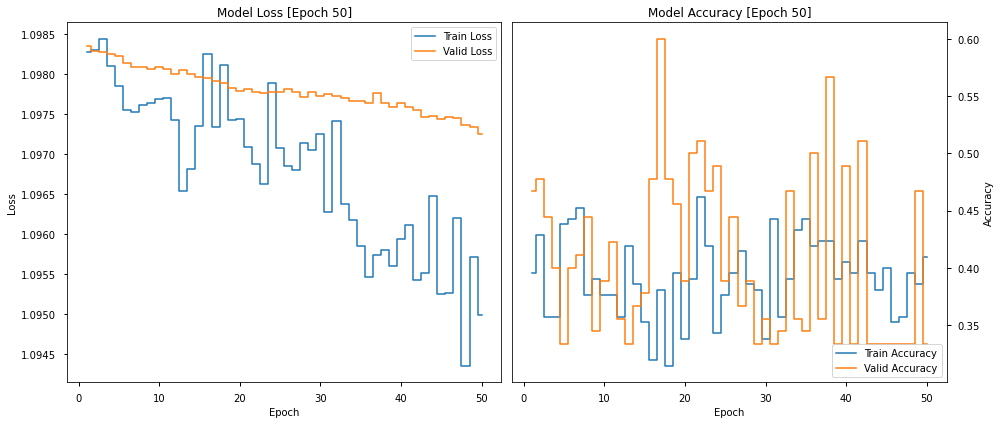

In [ ]:
#plot the train/valid loss and train/valid accuracy 
plot_train_curves(H.history)

In [ ]:
#applying all of the test data to the model. 
predictionsCNN = model.predict(cnnTestData)

#storing the highest predictions.
yPred = predictionsCNN.argmax(axis=1)

# Compare the truth with predictions and print a report
#yTrue = testGen.classes
report = classification_report(cnnTestLabels.argmax(axis=1),
                               yPred,
                               target_names=["HII","PNE","RG"])
print(report)

              precision    recall  f1-score   support

         HII       0.33      1.00      0.50        30
         PNE       0.00      0.00      0.00        30
          RG       0.00      0.00      0.00        30

    accuracy                           0.33        90
   macro avg       0.11      0.33      0.17        90
weighted avg       0.11      0.33      0.17        90



C:\Users\Rudol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting the confusion matrix:

Normalized confusion matrix
[[30  0  0]
 [30  0  0]
 [30  0  0]]


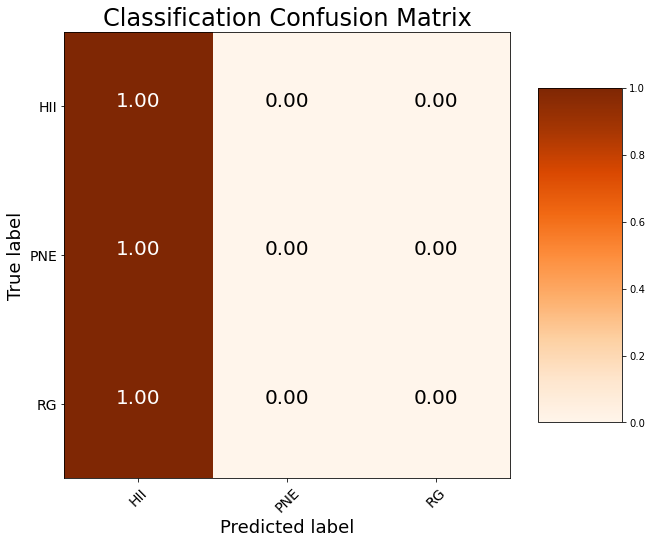

In [ ]:
cmatrix = confusion_matrix(cnnTestLabels.argmax(axis=1), yPred)
plot_confusion_matrix(cmatrix, classes = ['HII', 'PNE', 'RG'],
                      title = 'Classification Confusion Matrix', normalize=True)
print(cmatrix)

Prediction rate for false positives is very high. No RG predictions. Will need to tweak the model later. 

### HELP

## Evaluate the performance of the CNN



Once your model is trained, run a few predictions using the test data and compare with the known label. Then, produce a classification report using the test data. Using the saved history from your model fit, plot on separate graphs the evolution of the Training and Testing/Validation loss and the evolution of the Training and Testing/Validation accuracy. You can also use the plotting code from [lectorial in week 8](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/Solution_Notebooks/ASTR3110_Tutorial_8_Random_Forest.ipynb) to produce a confusion matrix to help assess the classifier. Based on the outputs of the classification report and the plots, assess the performance of the classifier.
</font>

### OLD 

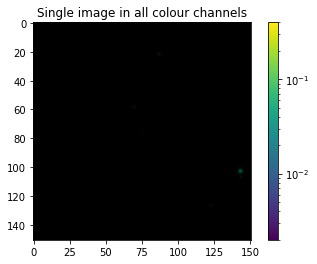

CNN model requires this shape: (1, 151, 151, 3)


In [ ]:
#choosing a single image from our testSet. This is from when we split the data. 
test1 = np.expand_dims(cnnTestData[10,:,:,:],axis=0) #

plt.imshow(cnnTestData[10,:,:,:], vmin=0.002, vmax= 0.4, norm=LogNorm()) #I've played around with the parameters vmin and 
#vmax to get a better image, though could not change any features on the plot. 

plt.colorbar()
plt.title('Single image in all colour channels')
plt.show()

print("CNN model requires this shape:",test1.shape)

# plt.imshow(test1[0].reshape(151, 151))

The image is dark because it's plotting all three colours. 

In [ ]:
predict1 = model.predict(test1, batch_size=3)
print("\nPredictions are a vector of probabilities:\n", predict1)

indx = np.argmax(predict1) 
print("\nPredicted digit is", lb.classes_[indx])
print(f'This digit corresponds to label: {cnnTestLabels[indx] }')
print('Labels correspond to HII = [1,0,0], PNE = [0,1,0] , RG = [0,0,1]')


Predictions are a vector of probabilities:
 [[0.33748522 0.3310792  0.33143562]]

Predicted digit is 0
This digit corresponds to label: [1 0 0]
Labels correspond to HII = [1,0,0], PNE = [0,1,0] , RG = [0,0,1]


Model has done a poor job, the labels have essentially the same probability of being predicted. 

### HELP

## Tweak the CNN to improve performance


As before, try to improve your classifier by changing the following:

- The learning rate and number of epochs (smaller learning rate generally requires more training epochs and vice versa).
- The number of hidden layers (only try 1-2 extra).
- The number of neurons in the layers (again, only try 1-2 different values).
- You may also try changing the input resolution of the images.

For each tweak, run the classification reports, generate a confusion matrix, and produce plots of the history of the Loss and Accuracy and give a brief assessment of the performance. 

Finally, give a summary report for the best classifier achieved, and outline which of the changes was most effective. How did your best CNN classifier compare with your best ANN classifier?</font>

### OLD

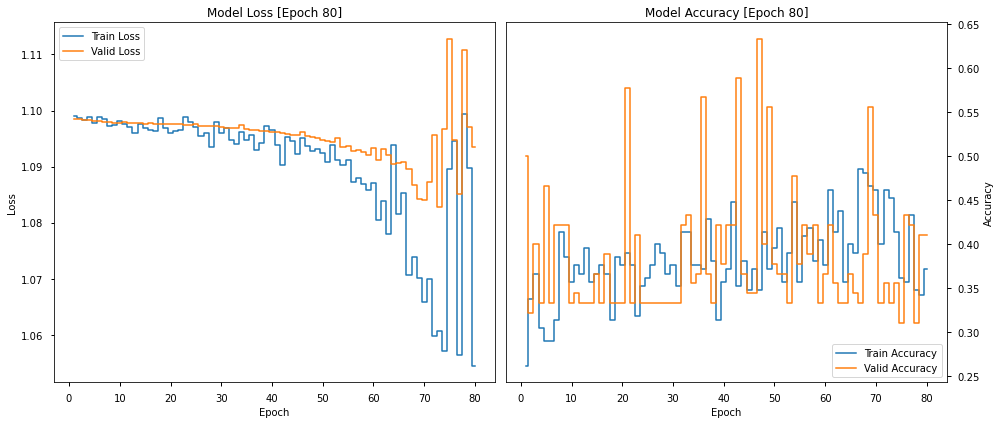

              precision    recall  f1-score   support

         HII       0.56      0.33      0.42        30
         PNE       0.00      0.00      0.00        30
          RG       0.38      0.90      0.53        30

    accuracy                           0.41        90
   macro avg       0.31      0.41      0.32        90
weighted avg       0.31      0.41      0.32        90

Normalized confusion matrix


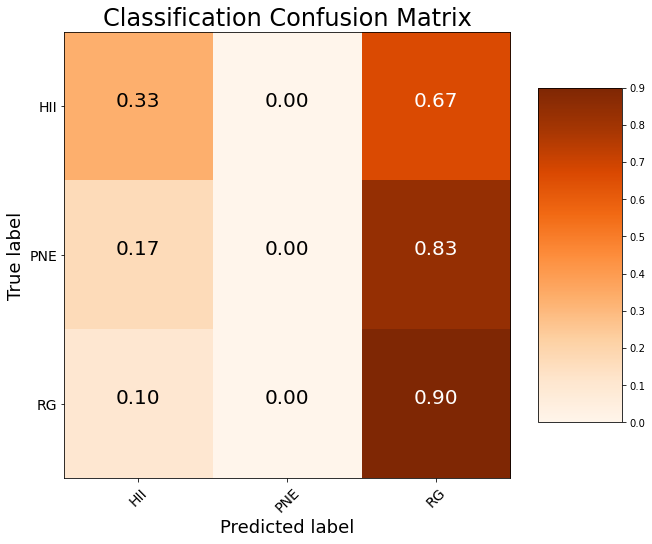

In [ ]:
#We've seen all of this previously...
model = Sequential()
size= cnnTrainData.shape[1]
inputShape = (size, size, 3)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (3, size, size)
    chanDim = 1

#_____________________________________________
#First layer
model.add(Conv2D(32, (3, 3), input_shape=inputShape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#_____________________________________________
#second layer
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#_____________________________________________
# third layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#_____________________________________________
#additional (fourth) layer
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#_____________________________________________
#additional (fifth) layer
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#_____________________________________________
#Flattening
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#_____________________________________________
#output layer
nClasses=3
model.add(Dense(nClasses))
model.add(Activation('softmax'))

#_____________________________________________
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
                  metrics=["accuracy"])

#_____________________________________________
batchSize = 8
nEpochs = 80

#_____________________________________________
H = model.fit(cnnTrainData, cnnTrainLabels, 
              validation_data=(cnnTestData, cnnTestLabels),
              batch_size=batchSize, epochs=nEpochs, verbose=0)

#_____________________________________________
#Plotting
plot_train_curves(H.history)
plt.show()

predictionsCNN = model.predict(cnnTestData)

yPred = predictionsCNN.argmax(axis=1)

report = classification_report(cnnTestLabels.argmax(axis=1), yPred, target_names=["HII","PNE","RG"])
print(report)

cmatrix = confusion_matrix(cnnTestLabels.argmax(axis=1), yPred)
plot_confusion_matrix(cmatrix, classes = ['HII', 'PNE', 'RG'], title = 'Classification Confusion Matrix', normalize=True)

The learn rate is lower for CNN compared to ANN as the CNN is longer but more accurate process. CNN is better at predicting PNE, where ANN struggled. It's important to note that PNE is more difficult to predict compared to the other two objects as it contains more features. I believe more features would require additional layers in the model. 

LearnRate (LR)=0.001, batch size(BS)= 32 epochs = 200
* high false-pos (f-p) prediction. No PNE prediction

Changed the batch size to 16 instead of the default 32 from the tute as we have less images. 

LR=0.001, epochs = 200
* high f-p, no PNE prediction. 

**No added layer** 
LR=  0.001, epochs=130
* two high f-p rates, no PNE prediction

LR= 0.01, epochs=130
* Loss function is much greater than one, high divergence at low epochs. Model has become less accurate since we've increased the learning rate (as expected).

** No added layer, changed one layer to 128 instead of 64 **
LearnRate (LR)=0.001, epochs = 200
* decent correct predictions, only f-p at ~50%, convergence at 130 epochs. 

LearnRate (LR)=0.001, epochs = 130
* Still a high f-p prediction, 

** two added layers, 128 and 256. **
LR= 0.001, epochs= 200
* only one f-p, high positive predictions except for PNE (expected), convergence at epoch ~130

LR= 0.001, epochs = 130
* two high f-p, no PNE. 

LR= 0.001, epochs= 200, BS= 8
* convergeance at 80 epochs, overfitted.

LR= 0.001, epochs= 80, BS=8 
* two high f-p. 

** Conclusion: 
two added layers with neurons 128 and 256 respectively have produced the best predictions with only a single false positive prediction. I thought lowering the batch size would help though it seems to do better with 16 than 8. Perhaps lowering the learn rate for the batch size of 8 would help as it gives more time to learn at every epoch for the reduced number of images fed to the model. 

### HELP

# (NOT ATTEMPTED) Stretch Goal: Data Augmentation 


It is possible to increase the size of our training set by manipulating the current data. For example, we can increase the size of our training set by rotating each image by 90, 180, and 270 degrees. Because our images of HII regions, PNE and RGs can have very similar shapes, but many different orientations on the sky, adding rotated images can help the CNN better learn our data. Aside from rotation, there are many other ways to augment the data, e.g., mirror-imaging, scaling the size, changing the perspective, and more.

Here, you can modify your training dataset using the ndimage.rotate function. In principle, you can add as many random orientations as you like, but I suggest that you start by rotating the three images for each source by 90, 180, and 270 degrees. You will need to also produce a new set of labels for your expanded dataset. Rerun your best CNN classifier on this new training set. Can you seen an improvement in performance?
</font>